In [42]:
import json
import h5py
import tqdm
import datetime
import time
import pandas as pd
import numpy as np
import collections

import importlib
import sys
sys.path.insert(0, '/cndd/fangming/CEMBA/snmcseq_dev')
sys.path.insert(0, '/cndd2/fangming/projects/SingleCellRoutines')

import __init__plots
importlib.reload(__init__plots)
from __init__plots import *

import snmcseq_utils
importlib.reload(snmcseq_utils)

import utils
importlib.reload(utils)

<module 'utils' from '/cndd2/fangming/projects/SingleCellRoutines/utils.py'>

In [2]:
today = datetime.date.today()
figures = '../figures/{}_{{}}'.format(today)
results = '../data/{}_{{}}'.format(today)
figures, results

('../figures/2021-05-28_{}', '../data/2021-05-28_{}')

# read in processed data

In [3]:
# palette as json
file = '../data/palette.json'
with open(file, 'r') as f:
    palette = json.load(f)
palette

{'Slice1_Replicate1': [0.19215686274509805,
  0.5098039215686274,
  0.7411764705882353],
 'Slice1_Replicate2': [0.4196078431372549,
  0.6823529411764706,
  0.8392156862745098],
 'Slice1_Replicate3': [0.6196078431372549,
  0.792156862745098,
  0.8823529411764706],
 'Slice2_Replicate1': [0.9019607843137255,
  0.3333333333333333,
  0.050980392156862744],
 'Slice2_Replicate2': [0.9921568627450981,
  0.5529411764705883,
  0.23529411764705882],
 'Slice2_Replicate3': [0.9921568627450981,
  0.6823529411764706,
  0.4196078431372549],
 'Slice3_Replicate1': [0.19215686274509805,
  0.6392156862745098,
  0.32941176470588235],
 'Slice3_Replicate2': [0.4549019607843137,
  0.7686274509803922,
  0.4627450980392157],
 'Slice3_Replicate3': [0.6313725490196078,
  0.8509803921568627,
  0.6078431372549019]}

In [4]:
!ls ../data/*.tsv.gz

../data/clustering_embedding_S1R1_S1R2_S1R3_S2R1_S2R2_S2R3_S3R1_S3R2_S3R3_2021-05-22.tsv.gz
../data/clustering_embedding_S1R2_2021-05-22.tsv.gz
../data/clustering_embedding_S2R1_2021-05-22.tsv.gz
../data/clustering_embedding_S2R1_S1R2_2021-05-22.tsv.gz
../data/clustering_embedding_Slice1_Replicate2_2021-05-18.tsv.gz
../data/clustering_embedding_Slice2_Replicate1_2021-05-15.tsv.gz


In [5]:
f = '../data/clustering_embedding_S1R1_S1R2_S1R3_S2R1_S2R2_S2R3_S3R1_S3R2_S3R3_2021-05-22.tsv.gz'
clsts = pd.read_csv(f, sep='\t').set_index('cell')
clsts['cluster_cat'] = pd.Categorical(clsts['cluster']) #.astype
print(clsts.shape)
clsts.head()

(692682, 5)


cluster    umap_1     umap_2  \
cell                                                                   
110883424764611924400221639916314253469     C14  1.417047   9.138863   
135188247894899244046039873973964001182     C14  1.260269   8.663673   
164766962839370328502017156371562646881     C14 -0.179721  10.929612   
165747897693809971960756442245389760838     C14  0.770016  10.161936   
260943245639750847364278545493286724628     C14  0.422456  10.411513   

                                                    sample cluster_cat  
cell                                                                    
110883424764611924400221639916314253469  Slice1_Replicate1         C14  
135188247894899244046039873973964001182  Slice1_Replicate1         C14  
164766962839370328502017156371562646881  Slice1_Replicate1         C14  
165747897693809971960756442245389760838  Slice1_Replicate1         C14  
260943245639750847364278545493286724628  Slice1_Replicate1         C14

In [10]:
input = '../data/processed_vizgen_merfish_may22_2021.hdf5'
samples = [
    'Slice1_Replicate1',
    'Slice1_Replicate2',
    'Slice1_Replicate3',
    
    'Slice2_Replicate1',
    'Slice2_Replicate2',
    'Slice2_Replicate3',
    
    'Slice3_Replicate1',
    'Slice3_Replicate2',
    'Slice3_Replicate3',
]

samples_shortname = "_".join([
    sample.replace('Slice', 'S').replace('_Replicate', 'R')
    for sample in samples
])

for sample in samples:
    gmat = []
    meta = []
    for sample in samples:
        _gmat = pd.read_hdf(input, 'mat_'+sample)
        gmat.append(_gmat)
        _meta = pd.read_hdf(input, 'meta_'+sample)
        _meta['sample'] = sample 
        meta.append(_meta)
gmat = pd.concat(gmat)
meta = pd.concat(meta)


In [21]:
# informations
thedata = clsts.drop('sample', axis=1).join(meta) #.join(clsts)
genes = gmat.columns
thedatagmat = thedata.join(gmat)
print(len(genes), gmat.shape, thedata.shape)

483 (692682, 483) (692682, 17)


# plotting functions

In [8]:
# unify cluster palette 
# cmap chage
uniq_clsts = np.sort(clsts['cluster'].unique())
colors = sns.color_palette('husl', len(uniq_clsts))
palette_clsts = {clst: color for clst, color in zip(uniq_clsts, colors)}

## Try datashader

In [9]:
import datashader as ds
import colorcet

In [36]:
class PlotScale:
    """
    arguments: rangex, ragey, [npxlx, npxly, pxl_scale]
    
    one of the three in [] will be required
    """
    def __init__(self, rangex, rangey, npxlx=0, npxly=0, pxl_scale=0):
        """
        """
        # 1 of the three optional args need to be set
        assert (np.array([npxlx, npxly, pxl_scale])==0).sum() == 2 
        self.rangex = rangex
        self.rangey = rangey
        
        if pxl_scale:
            pxl_scale = pxl_scale
            npxlx = int(rangex/pxl_scale)
            npxly = int(rangey/pxl_scale)
        if npxlx:
            npxlx = int(npxlx)
            pxl_scale = rangex/npxlx 
            npxly = int(rangey/pxl_scale)
        if npxly:
            npxly = int(npxly)
            pxl_scale = rangey/npxly 
            npxlx = int(rangex/pxl_scale)
        self.pxl_scale = pxl_scale
        self.npxlx = npxlx
        self.npxly = npxly
        
    def len2pixel(self, length):
        """
        """
        return int(length/self.pxl_scale) 
    
    def pixel2len(self, npixel):
        """
        """
        return npixel*self.pxl_scale

def agg_data(
    data, 
    x, y, 
    npxlx, npxly, 
    agg,
    ):
    """
    """
    aggdata = ds.Canvas(plot_width=npxlx, plot_height=npxly).points(data, x, y, agg=agg)
    return aggdata

def imshow_routine(
    ax, 
    aggdata,
    cmap=colorcet.cm.gray_r,
    ):
    """
    """
    ax.imshow(aggdata, aspect='equal', cmap=cmap)
    ax.invert_yaxis()
    ax.axis('off')
    return ax 

def massive_scatter_plot(
    ax, 
    data, 
    x, y,  
    npxlx, npxly, 
    agg=ds.count(),
    cmap=colorcet.cm.gray_r,
    ):
    """
    """
    aggdata = agg_data(data, x, y, npxlx, npxly, agg)
    imshow_routine(ax, aggdata, cmap=cmap)
    return ax 

def add_arrows(
    ax, label, fontsize=15,
    ):
    """
    """
    # arrows
    ax.arrow(0, 0, 0, 0.1,
             transform=ax.transAxes,
             head_width=0.01, head_length=0.01, fc='k', ec='k', clip_on=False)
    ax.arrow(0, 0, 0.1, 0,
             transform=ax.transAxes,
             head_width=0.01, head_length=0.01, fc='k', ec='k', clip_on=False)
    ax.text(0, -0.01, 'In situ', 
            transform=ax.transAxes,
            va='top', ha='left', 
            fontsize=fontsize)
    # end arrows
    return ax

def add_scalebar(
    ax, left, right, label, fontsize=15, 
    ):
    """
    """
    ax.hlines(0, left, right, color='k', linewidth=3, 
              transform=ax.get_xaxis_transform())
    ax.text(right, -0.01, label, 
            va='top', ha='right', 
            transform=ax.get_xaxis_transform(),
            fontsize=fontsize)
    # end scale bar
    return ax

def plot_insitu_routine(ax, data, x, y, agg, scale_paras, cmap, title):
    """
    """
    # main
    rangex = data[x].max() - data[x].min()
    rangey = data[y].max() - data[y].min()
    ps = PlotScale(rangex, rangey, **scale_paras)
    massive_scatter_plot(ax, data, x, y, ps.npxlx, ps.npxly, 
                         agg=agg, 
                         cmap=cmap,
                        )
    ax.set_title(title)
    # arrows
    add_arrows(ax, 'in situ')
    # scale bar
    bar_length = 1000 # (micron)
    add_scalebar(ax, ps.npxlx-ps.len2pixel(bar_length), ps.npxlx, '1 mm')
    return ax

In [ ]:
# quantify all 483 genes in one pass seems too slow and generate more data than raw
# we need to run on the file

# x, y = 'x', 'y'
# z_genes = collections.OrderedDict(
#     {gene: ds.mean(gene) for gene in genes}
# )
# agg = ds.summary(**z_genes)
# scale_paras = dict(
#     pxl_scale=200,
# )


# fig, axs = plt.subplots(3, 3, figsize=(9*3,6*3))
# for i, sample in enumerate(samples):
#     data = thedatagmat[thedatagmat['sample']==sample]
#     title = sample
    
#     # ps
#     rangex = data[x].max() - data[x].min()
#     rangey = data[y].max() - data[y].min()
#     ps = PlotScale(rangex, rangey, **scale_paras)
    
#     aggdata = agg_data(data, x, y, ps.npxlx, ps.npxly, agg,)
#     ax = axs.flat[i]
#     imshow_routine(ax, aggdata[z_genes[0]])
    
    
#     break
    
    
# aggdata

In [34]:
aggdata['mean_a'].values

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

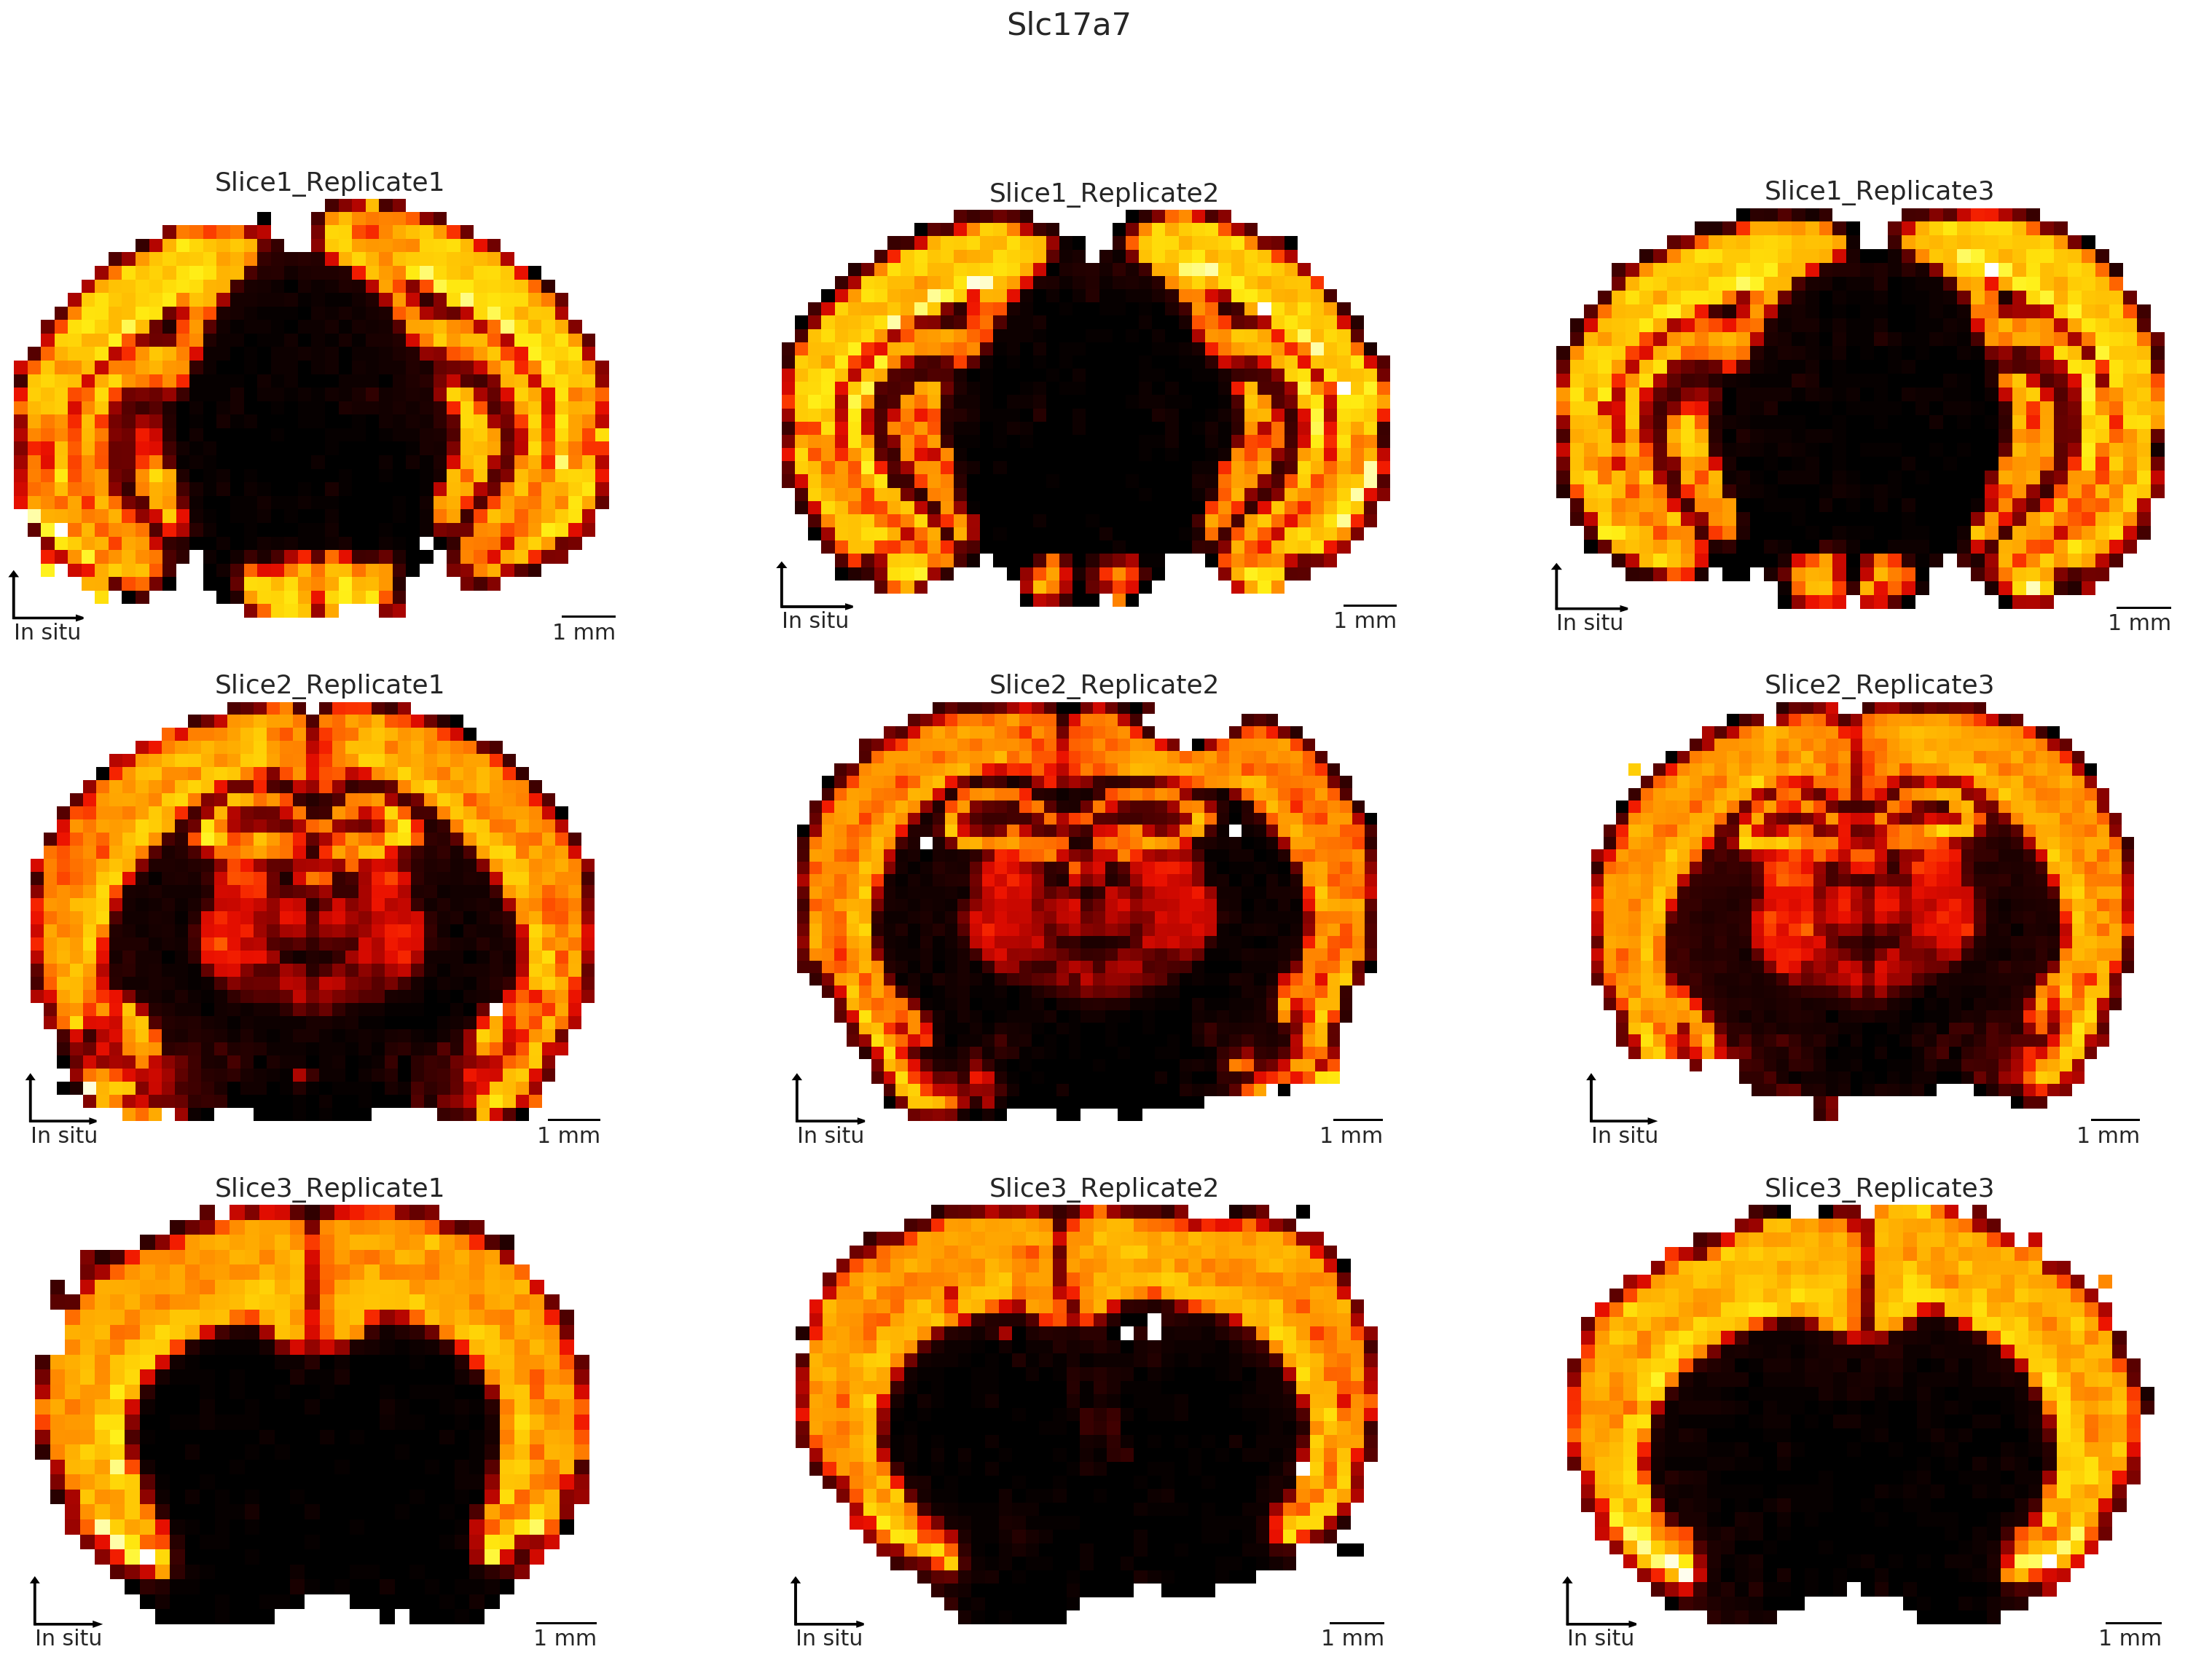

In [25]:
x, y = 'x', 'y'
hue = 'Slc17a7'
agg = ds.mean(hue)
scale_paras = dict(
    pxl_scale=200,
)

# cmap = colorcet.cm.gray_r
cmap = colorcet.cm.fire

fig, axs = plt.subplots(3, 3, figsize=(9*3,6*3))
for ax, sample in zip(axs.flat, samples):
    data = thedatagmat[thedatagmat['sample']==sample]
    title = sample
    plot_insitu_routine(ax, data, x, y, agg, scale_paras, cmap, title)
fig.suptitle(hue, y=0.98)
plt.show()

In [18]:
# agg = cvs.points(thedata, 'x', 'y', agg=ds.count())
# # agg2 = cvs.points(thedata, 'x', 'y', agg=ds.by('cluster_cat', ds.count()))

# ds.tf.Images(
#     ds.tf.shade(agg, cmap=colorcet.fire), 
# # # #     tf.shade(agg2), 
# # # #     tf.shade(agg), 
# # # #     tf.shade(agg3), 
# # #     tf.shade(agg4, color_key=[palette_clsts[clst] for clst in palette_clsts.keys()]), 
#     )

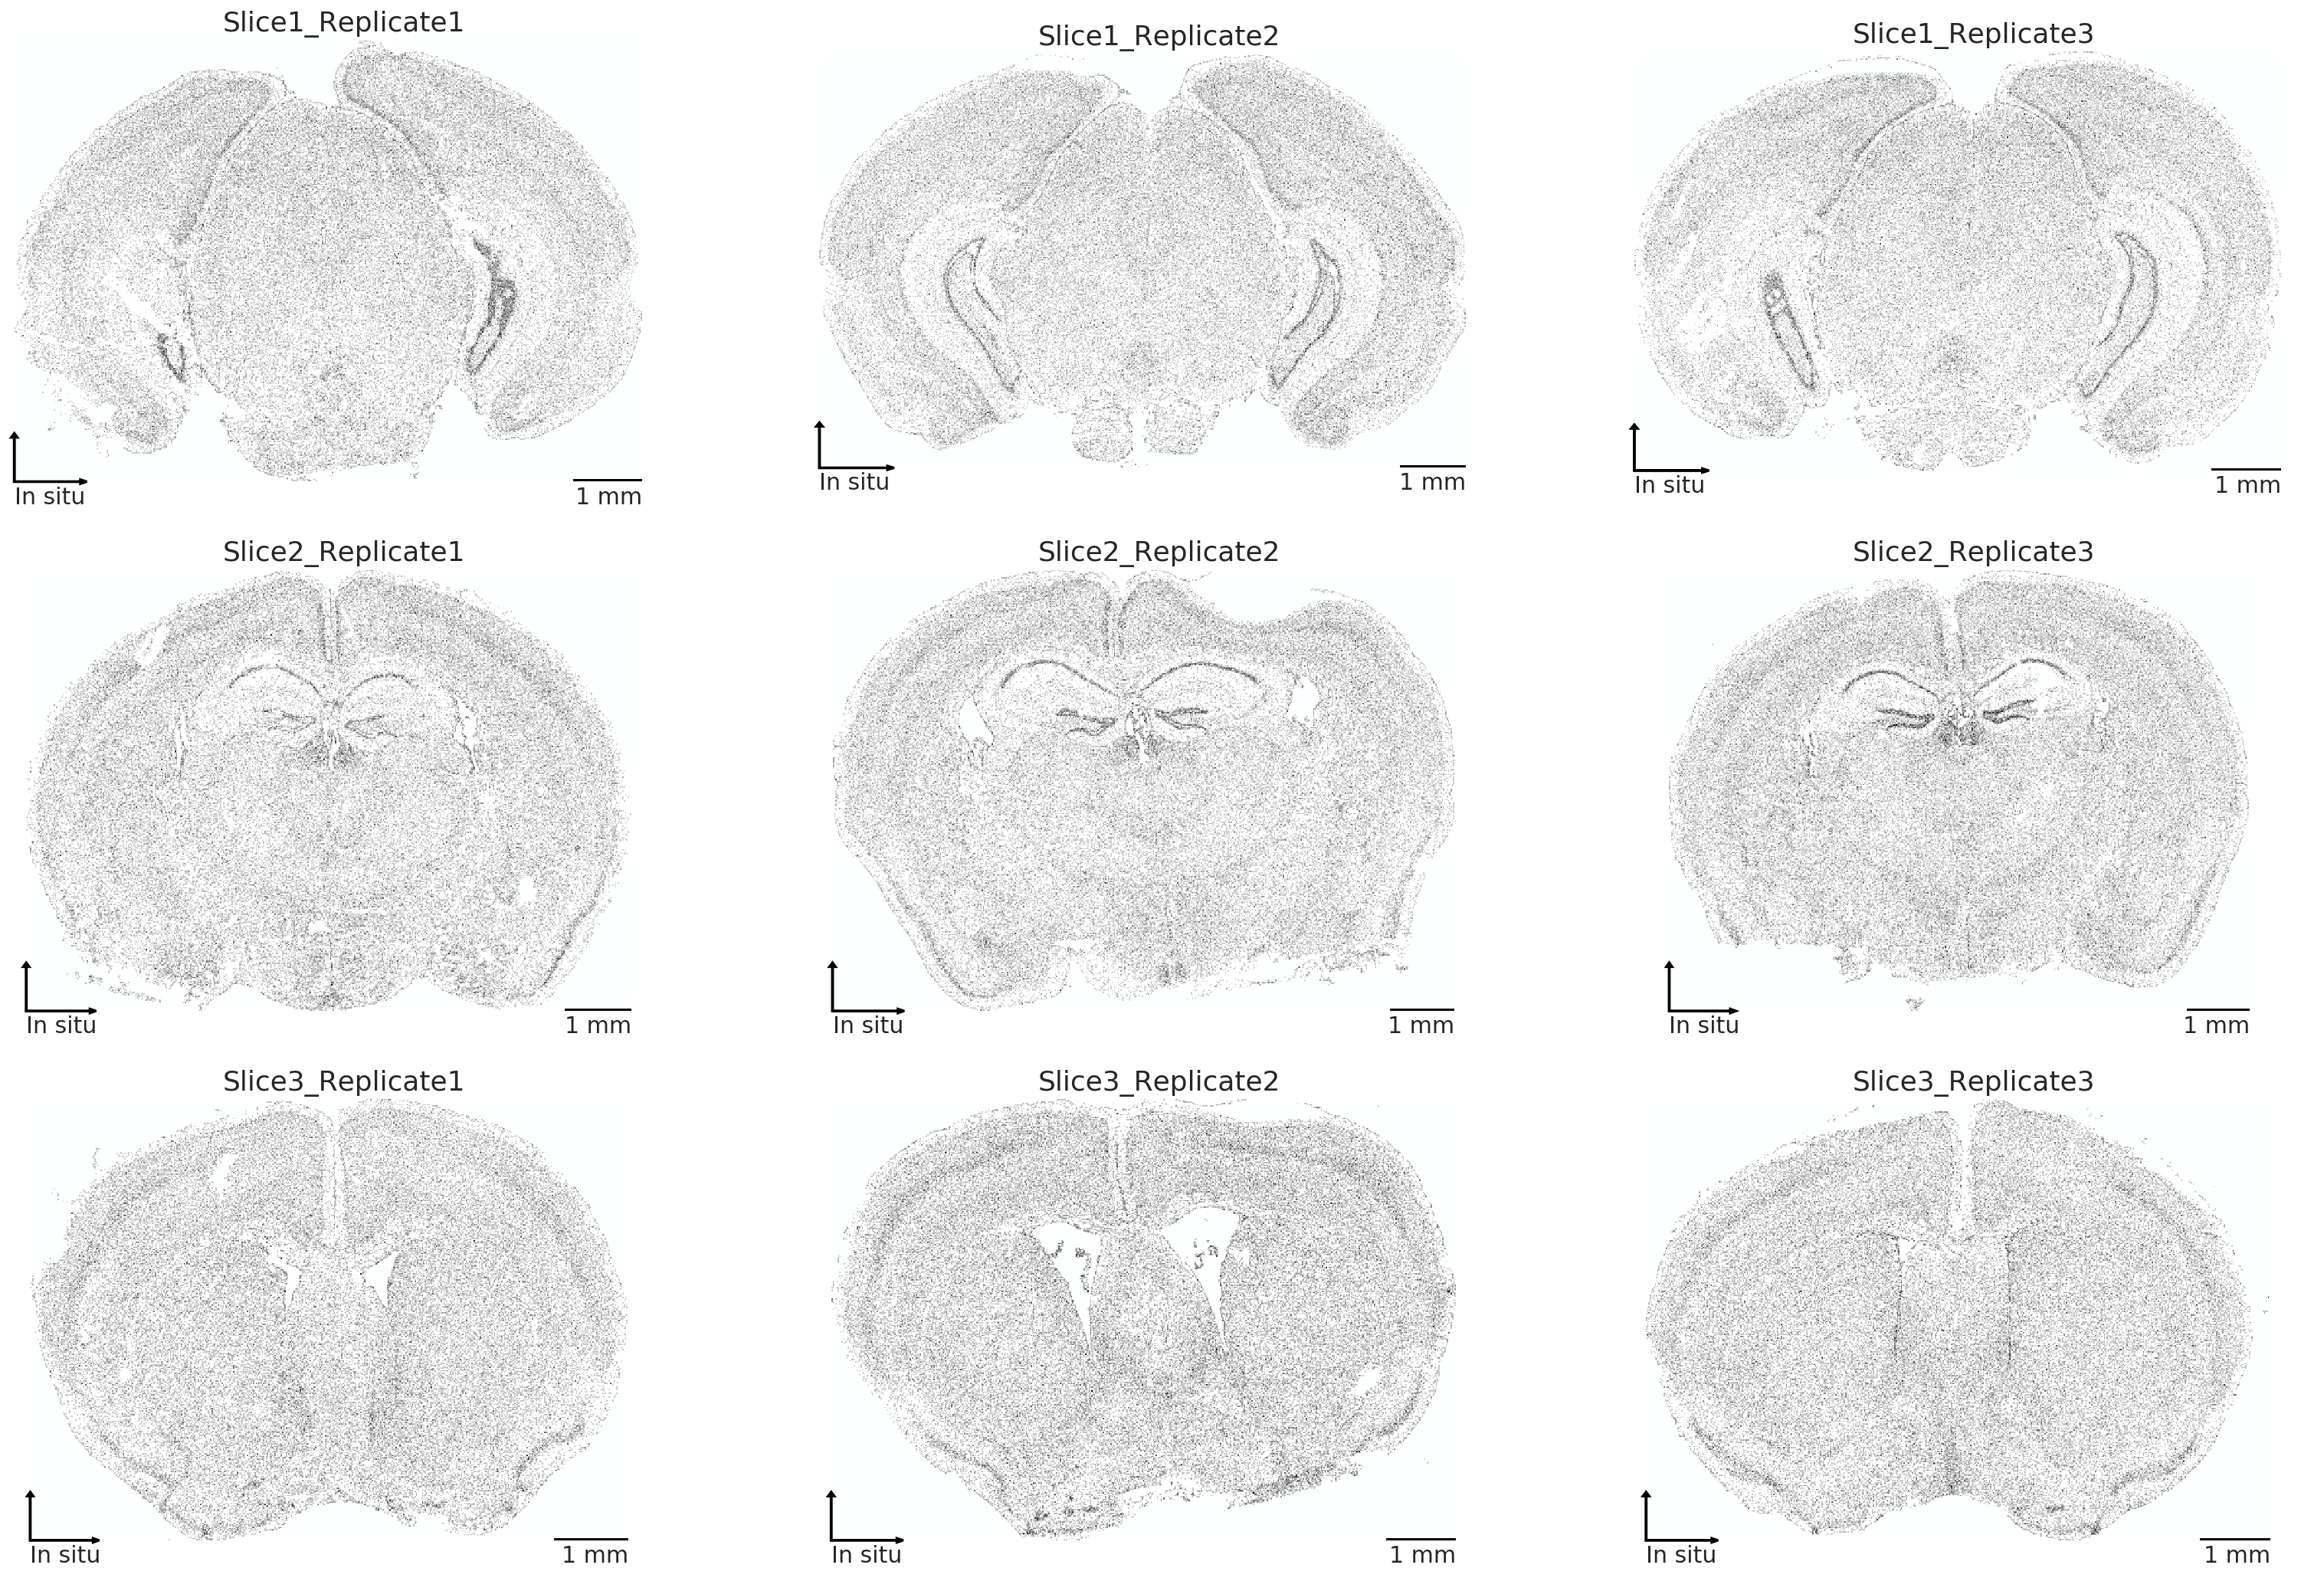

In [19]:
x, y = 'x', 'y'
agg = ds.count()
# agg = ds.mean('volume')
scale_paras = dict(
#        npxlx=500,
    npxly=350, 
#         pxl_scale=20,
)
cmap = colorcet.cm.gray_r
# cmap = ['white', 'black']
# cmap = colorcet.cm.fire

fig, axs = plt.subplots(3, 3, figsize=(9*3,6*3))
for ax, sample in zip(axs.flat, samples):
    data = thedata[thedata['sample']==sample]
    title = sample
    plot_insitu_routine(ax, data, x, y, agg, scale_paras, cmap, title)
    
plt.show()

In [26]:
thedatagmat = thedata.join(gmat)

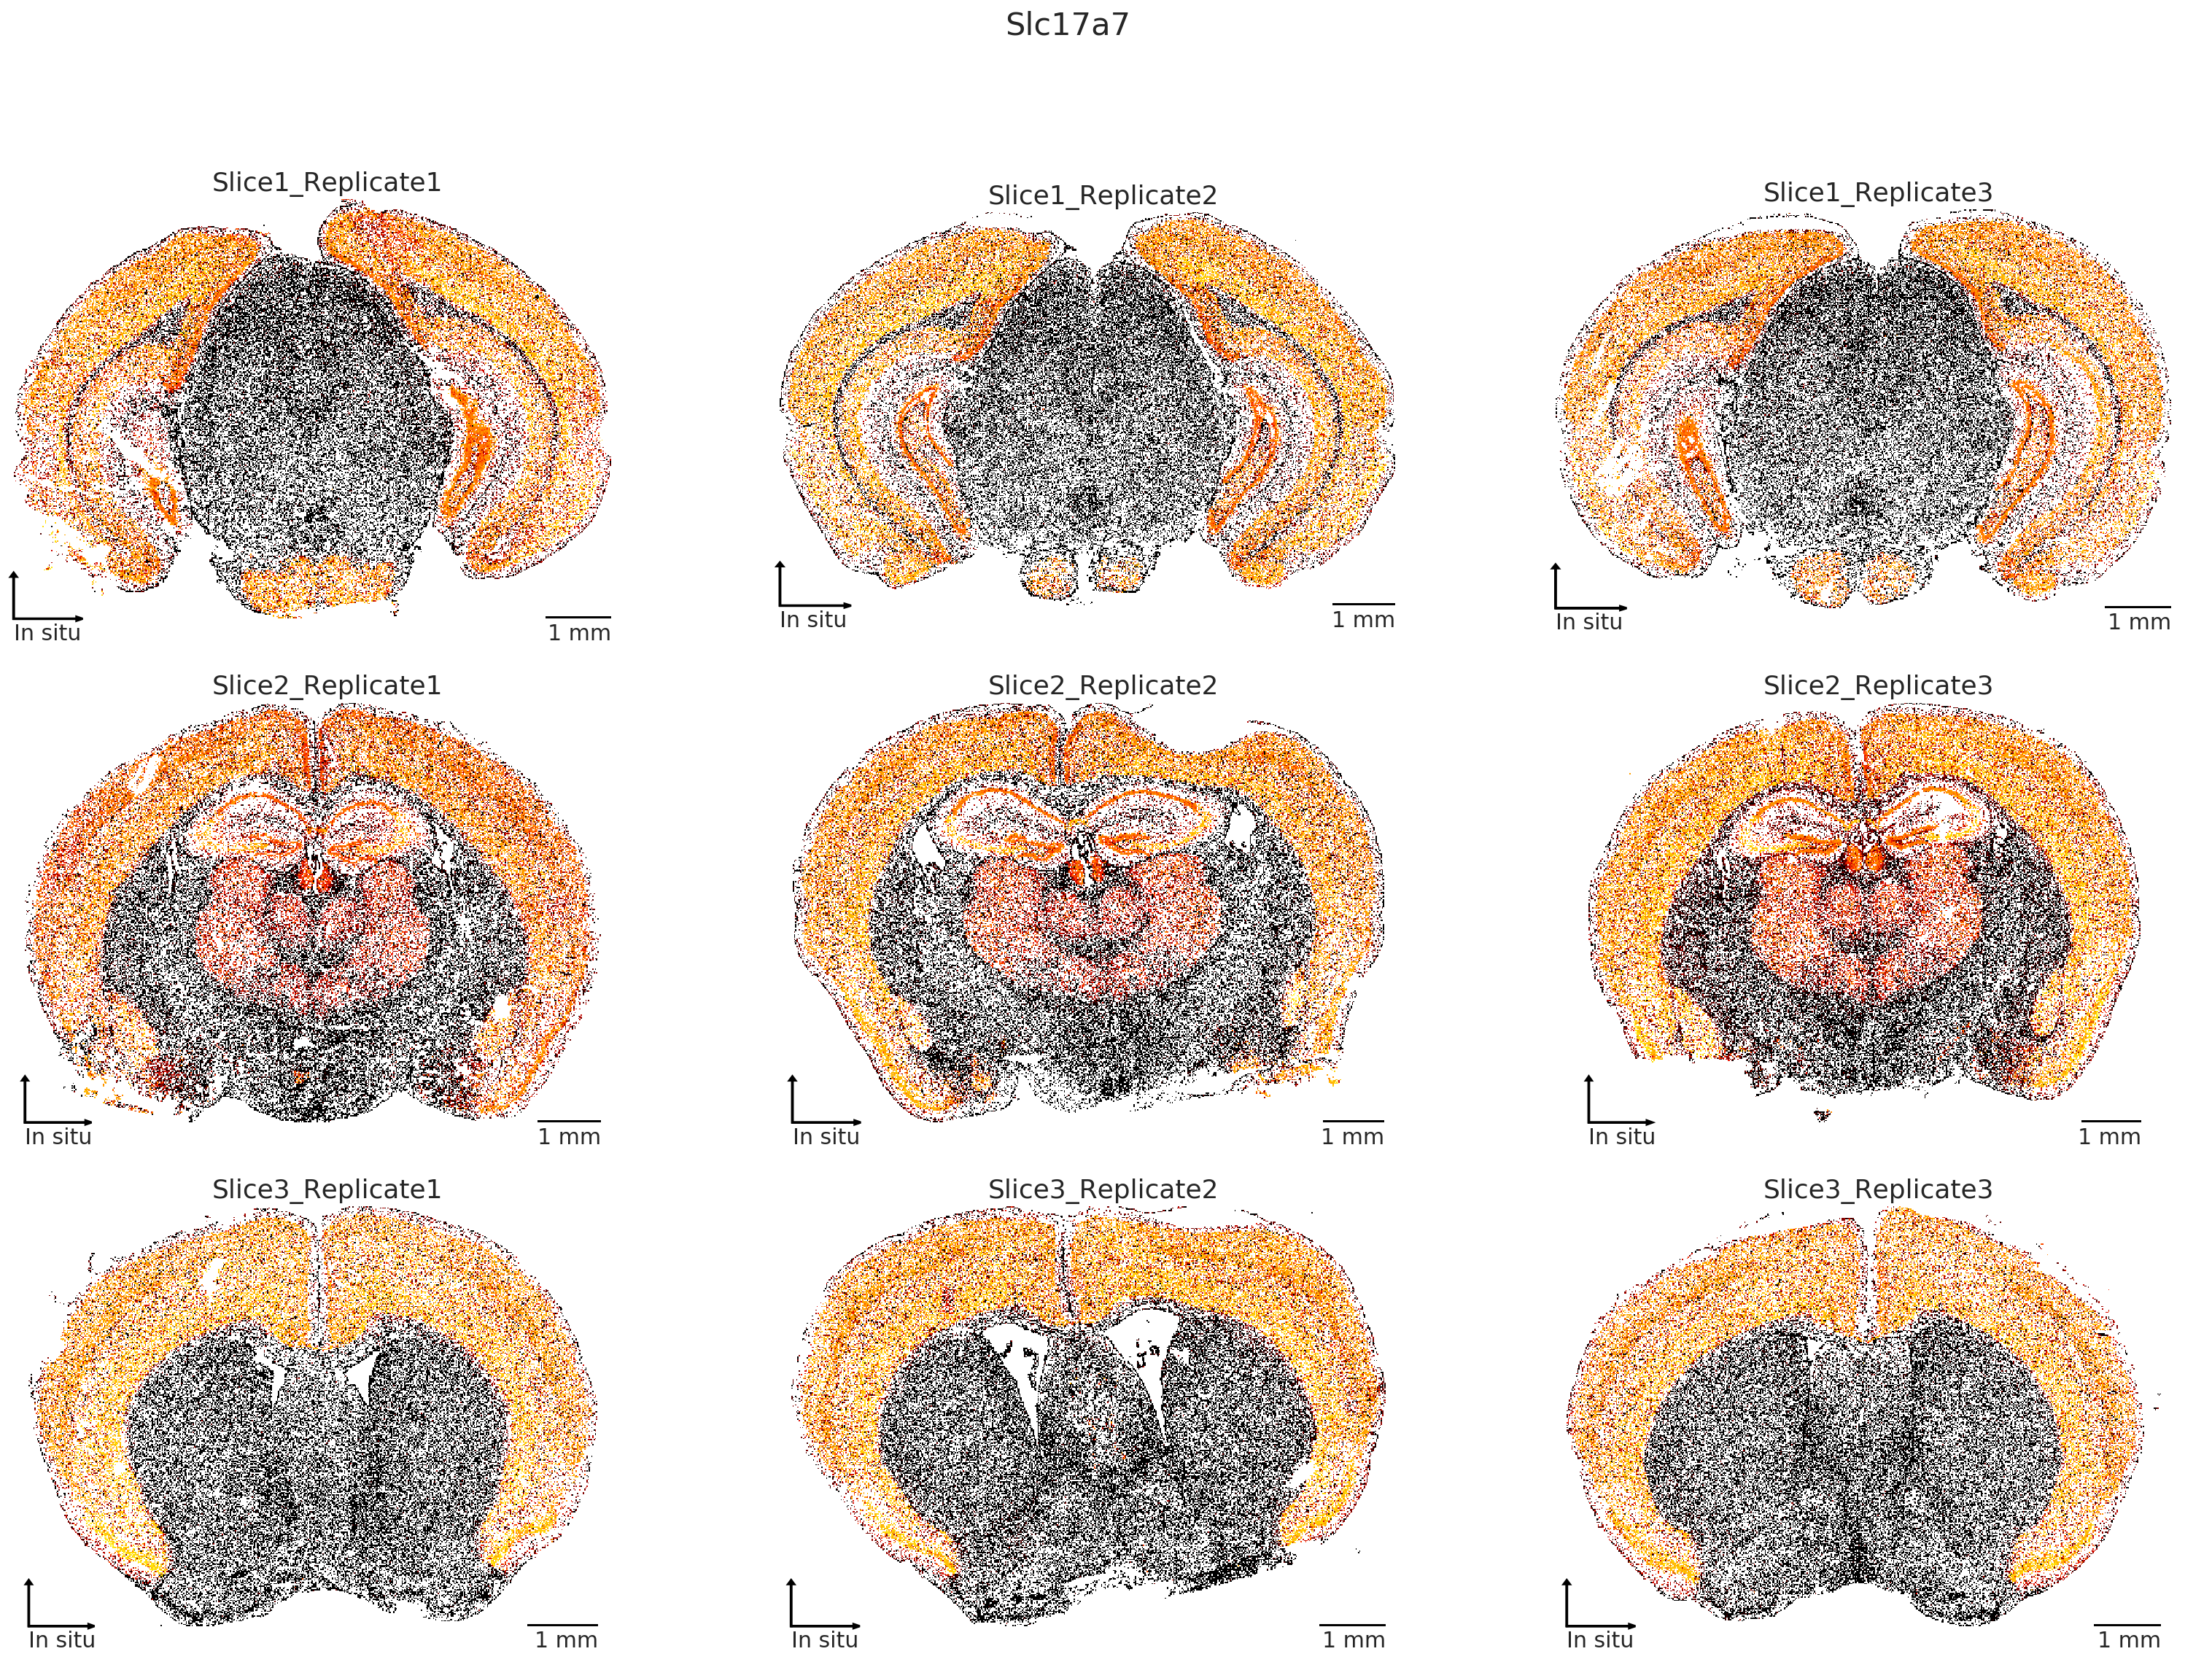

In [53]:
x, y = 'x', 'y'
hue = 'Slc17a7'
agg = ds.mean(hue)
scale_paras = dict(
    npxly=350, 
)
# cmap = colorcet.cm.gray_r
cmap = colorcet.cm.fire

fig, axs = plt.subplots(3, 3, figsize=(9*3,6*3))
for ax, sample in zip(axs.flat, samples):
    data = thedatagmat[thedatagmat['sample']==sample]
    title = sample
    plot_insitu_routine(ax, data, x, y, agg, scale_paras, cmap, title)
fig.suptitle(hue, y=0.98)
plt.show()

In [58]:
data.head()

cluster    umap_1    umap_2  \
cell                                                                  
248024456595654429600598295124535343200     C14  1.184472  8.099537   
248517492611370834464009662840236881305     C14  1.212898  8.241783   
267194455595590501971330204981279503222      C4  1.768462  6.544517   
80719596629301901340444638136238672607      C14  1.114473  7.900785   
185300591460888744904914280441592422179     C14  1.112032  8.490226   

                                                   x            y  fov  \
cell                                                                     
248024456595654429600598295124535343200 -2816.939692 -2585.356593   12   
248517492611370834464009662840236881305 -2824.661196 -2589.319193   12   
267194455595590501971330204981279503222 -2831.013698 -2582.409286   12   
80719596629301901340444638136238672607  -2851.685262 -2569.008578   12   
185300591460888744904914280441592422179 -2682.429669 -2652.137858   13   

                                              volume    center_x     center_y  \
cell                                                                            
248024456595654429600598295124535343200   460.431146  416.982612  6039.899981   
248517492611370834464009662840236881305  1489.933543  410.022012  6045.083982   
267194455595590501971330204981279503222   432.760783  413.424012  6053.831982   
80719596629301901340444638136238672607    297.297646  416.340012  6078.293982   
185300591460888744904914280441592422179   456.058808  416.334612  5889.725870   

                                              min_x       max_x        min_y  \
cell                                                                           
248024456595654429600598295124535343200  412.873212  421.092012  6033.949181   
248517492611370834464009662840236881305  401.209212  418.834812  6033.625181   
267194455595590501971330204981279503222  409.741212  417.106812  6048.313182   
80719596629301901340444638136238672607   412.765212  419.914812  6074.233182   
185300591460888744904914280441592422179  411.577212  421.092012  5883.937069   

                                               max_y  cell_cov  cell_cov_norm  \
cell                                                                            
248024456595654429600598295124535343200  6045.850782     117.0     217.087297   
248517492611370834464009662840236881305  6056.542782     332.0     190.363828   
267194455595590501971330204981279503222  6059.350782     109.0     215.175015   
80719596629301901340444638136238672607   6082.354783      77.0     221.264886   
185300591460888744904914280441592422179  5895.514670      88.0     164.844730   

                                                    sample cluster_cat  
cell                                                                    
248024456595654429600598295124535343200  Slice3_Replicate3         C14  
248517492611370834464009662840236881305  Slice3_Replicate3         C14  
267194455595590501971330204981279503222  Slice3_Replicate3          C4  
80719596629301901340444638136238672607   Slice3_Replicate3         C14  
185300591460888744904914280441592422179  Slice3_Replicate3         C14

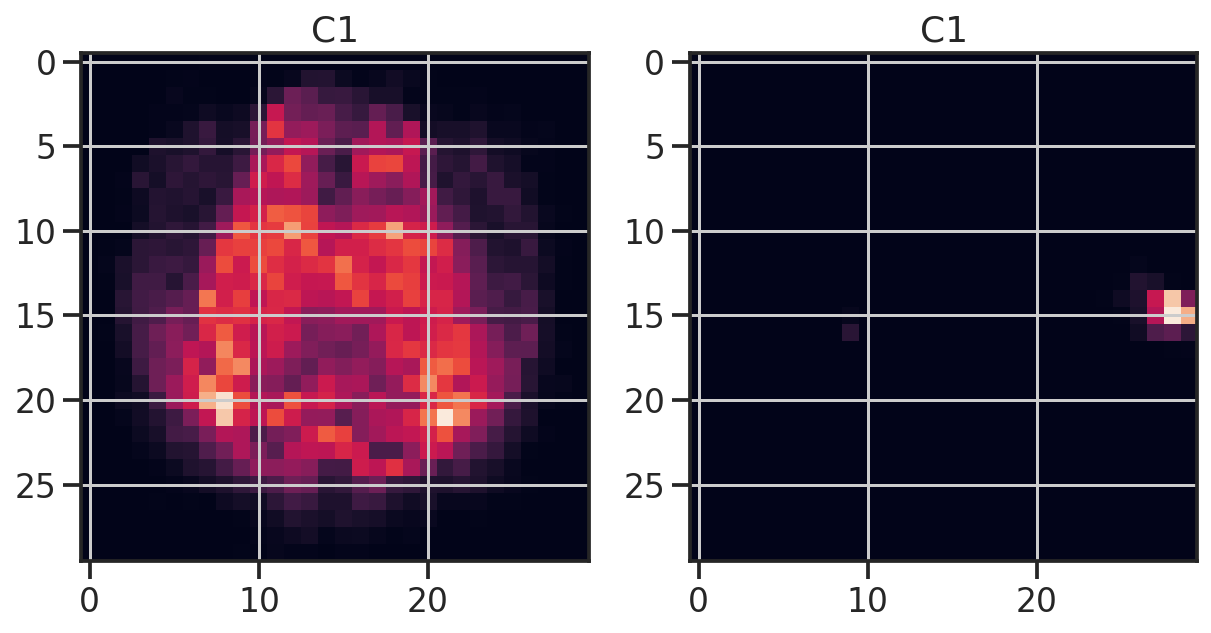

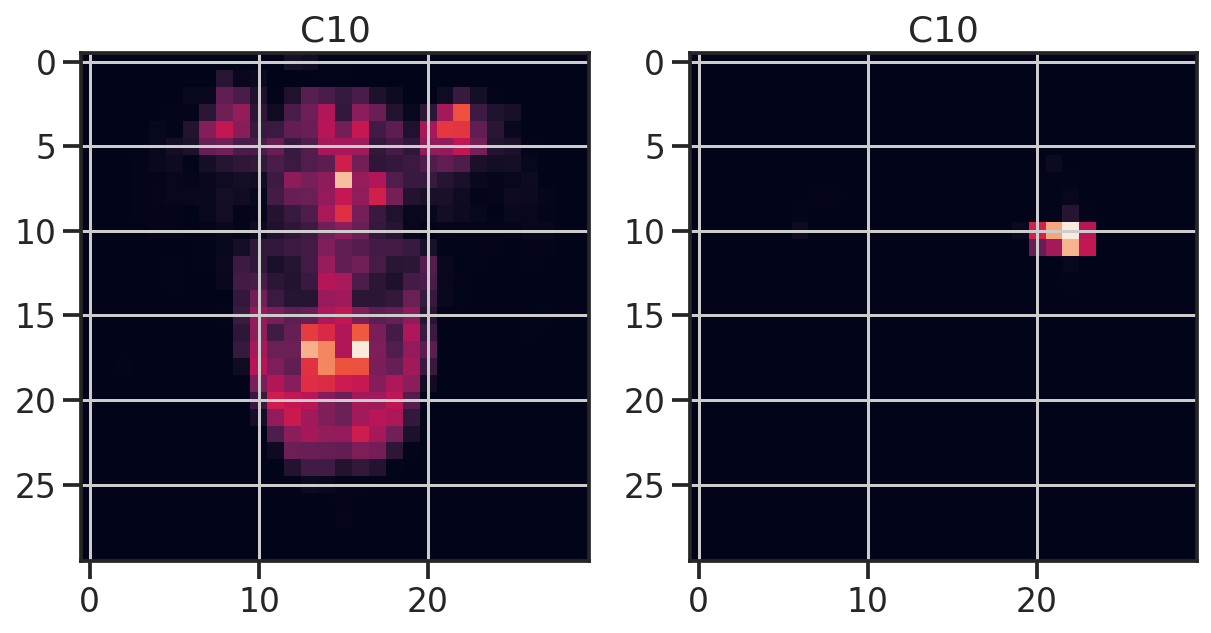

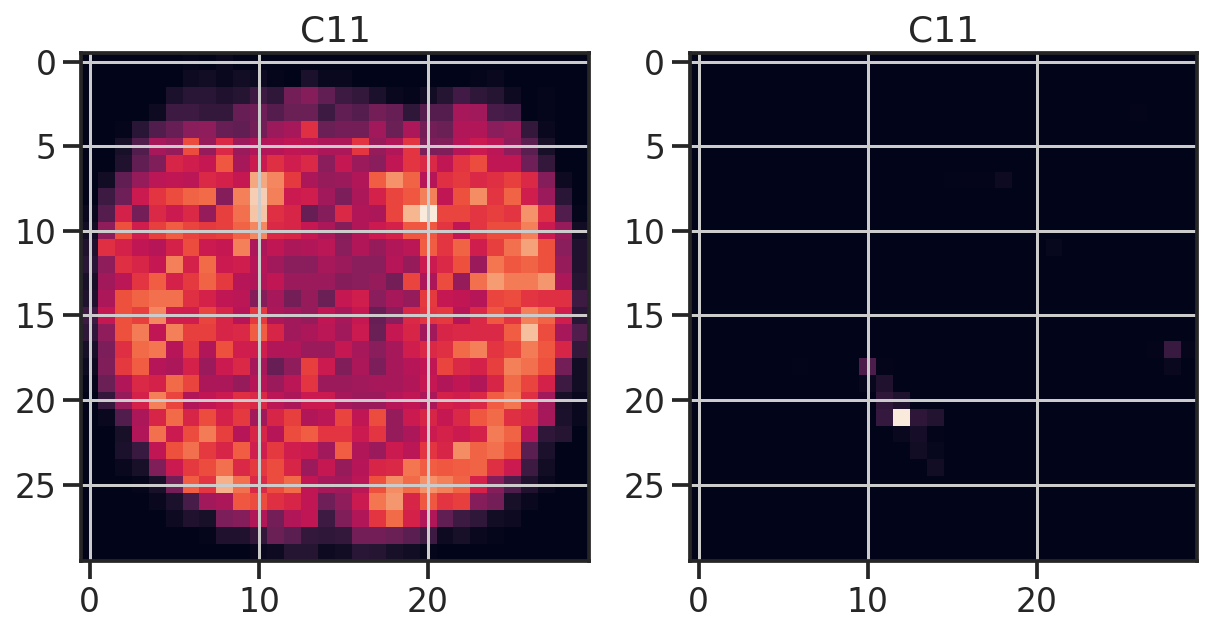

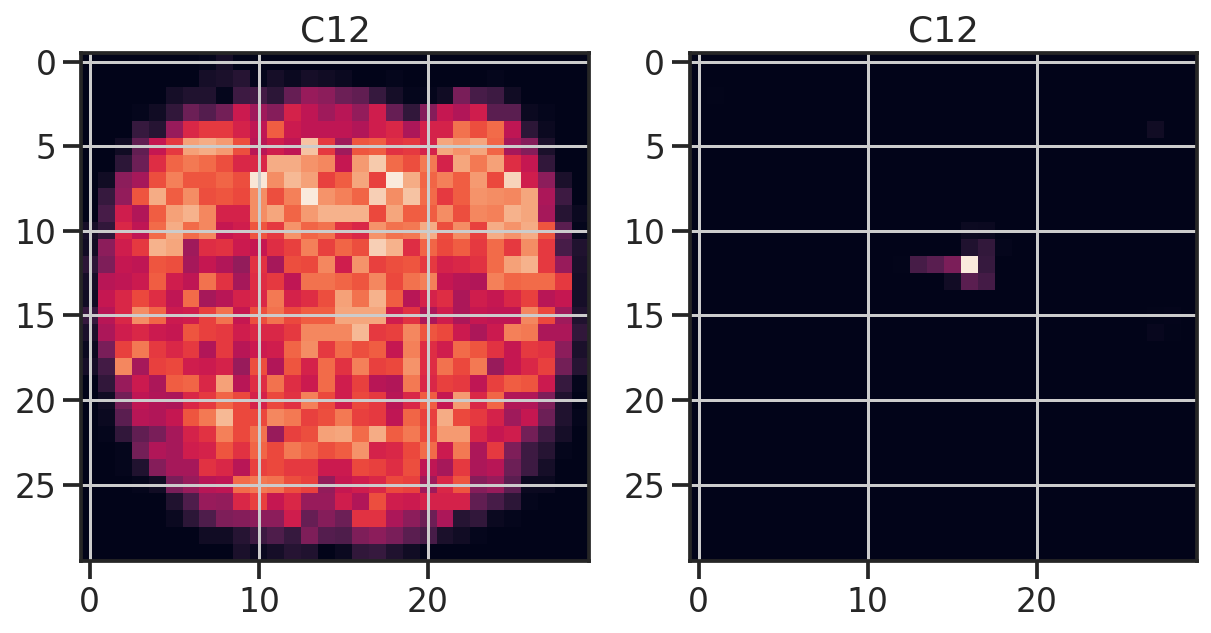

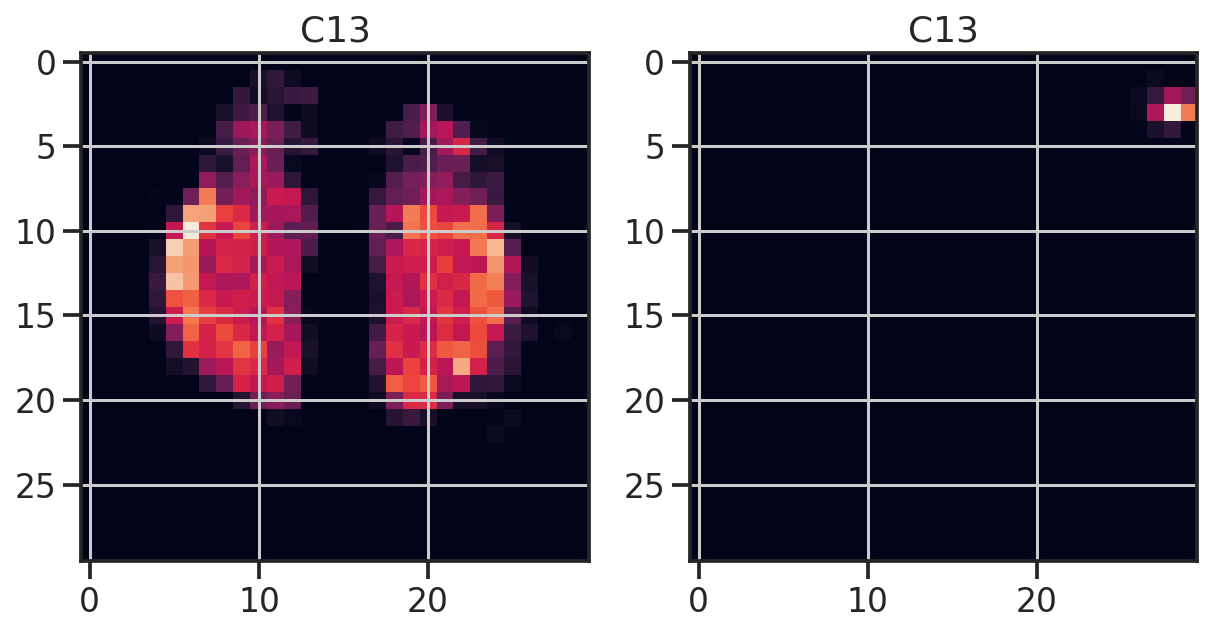

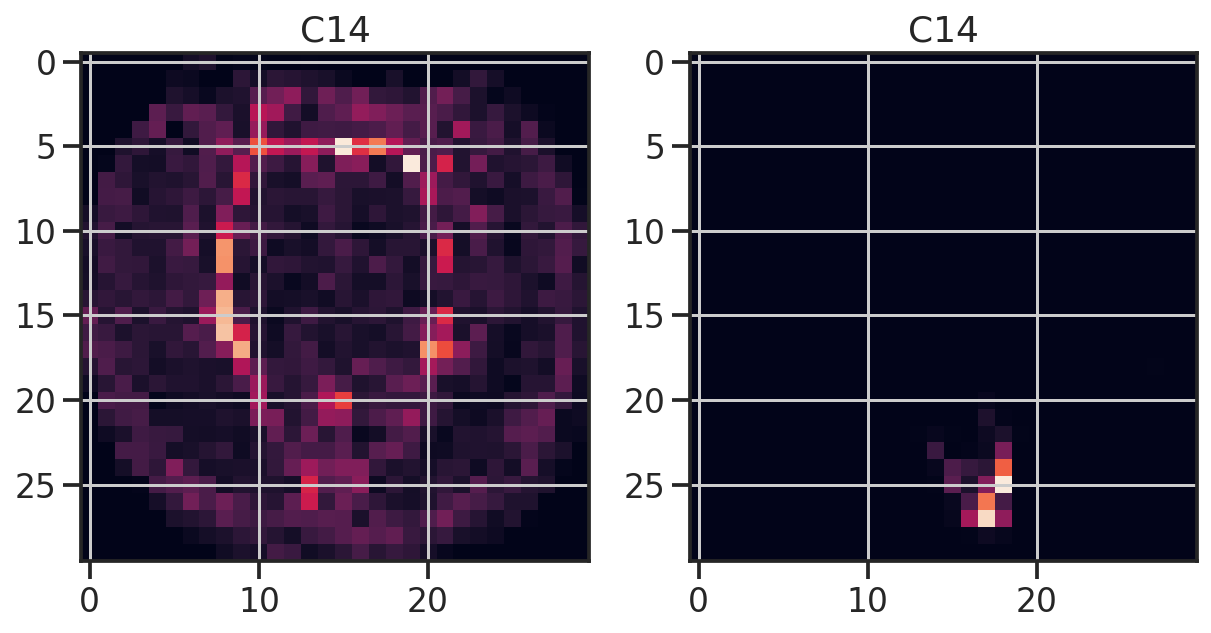

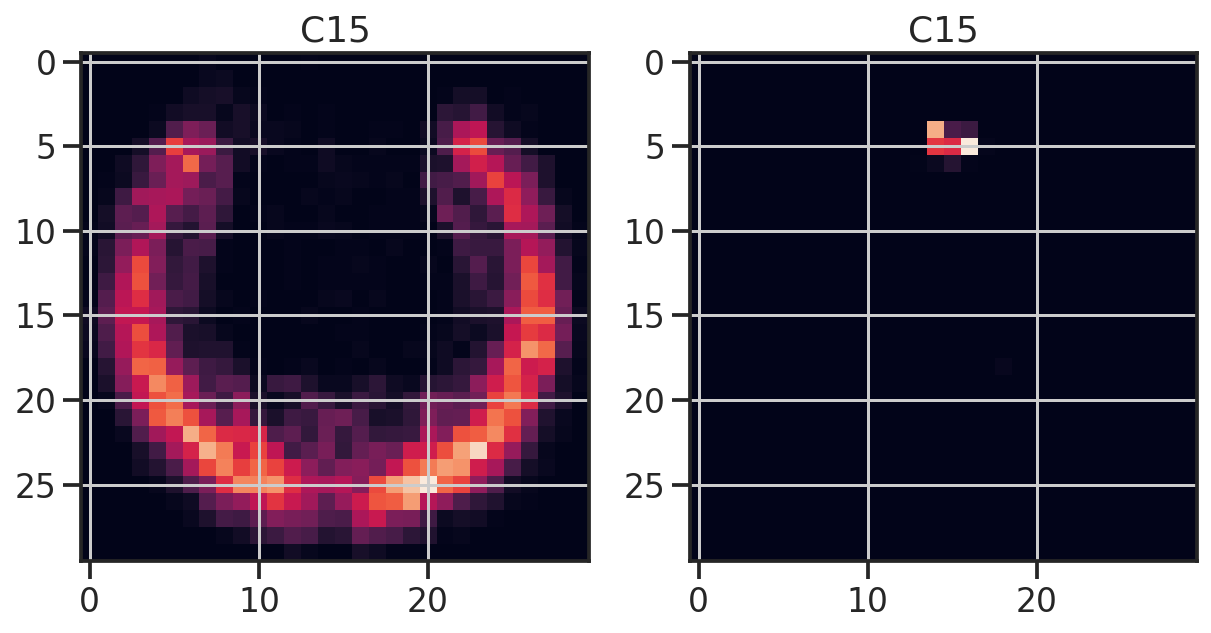

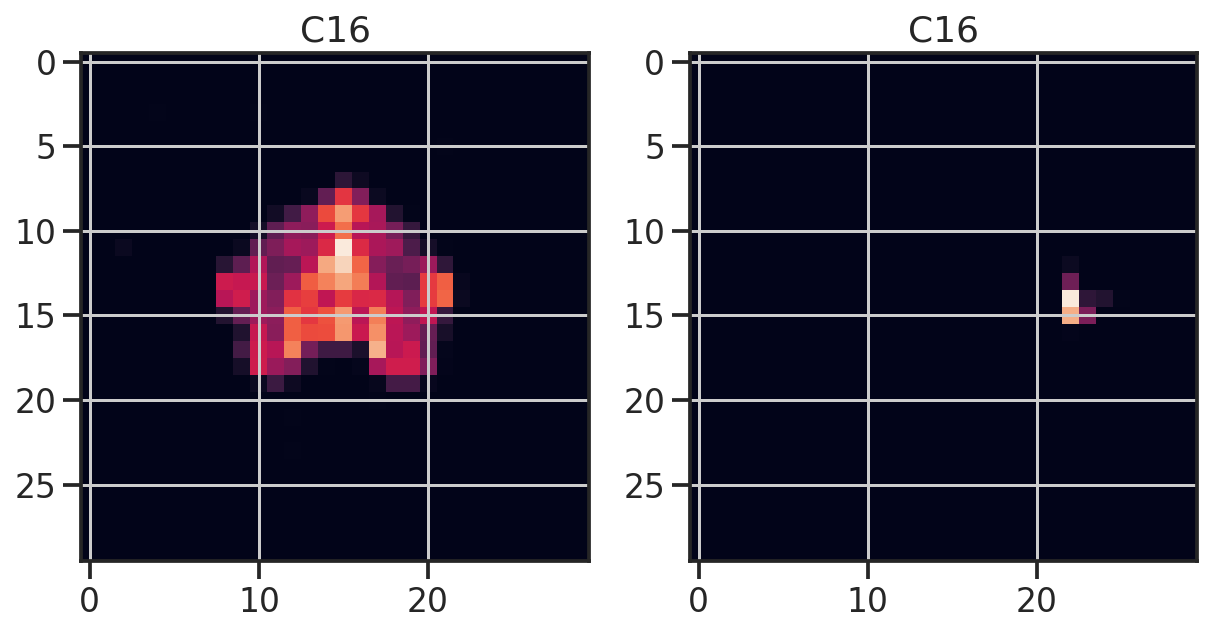

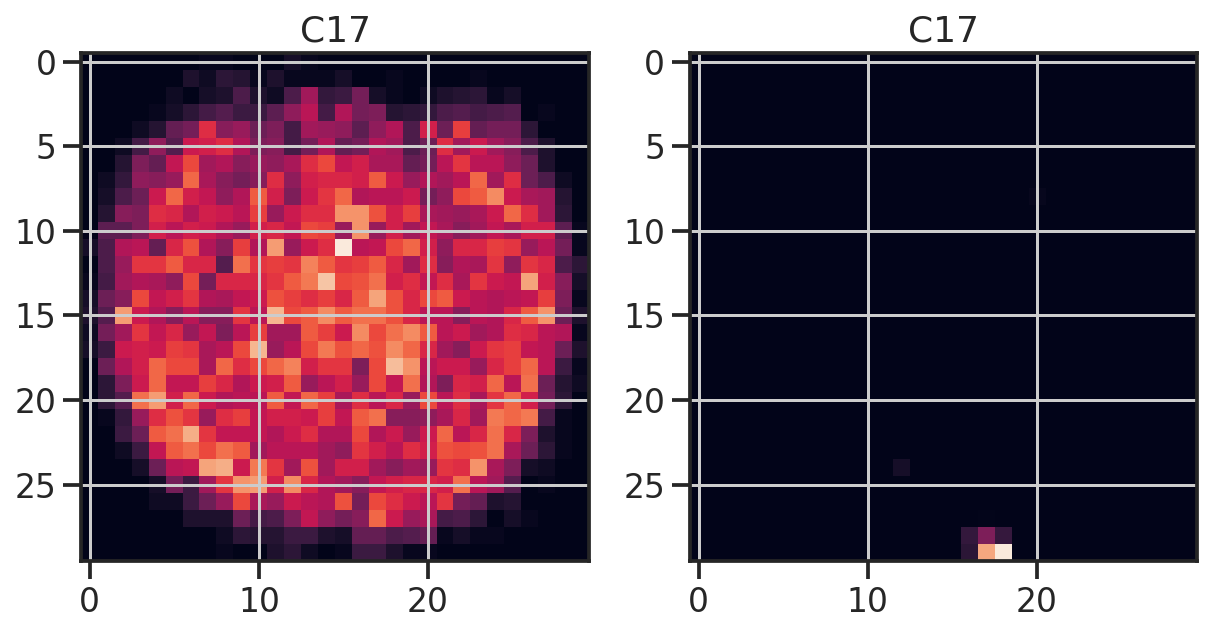

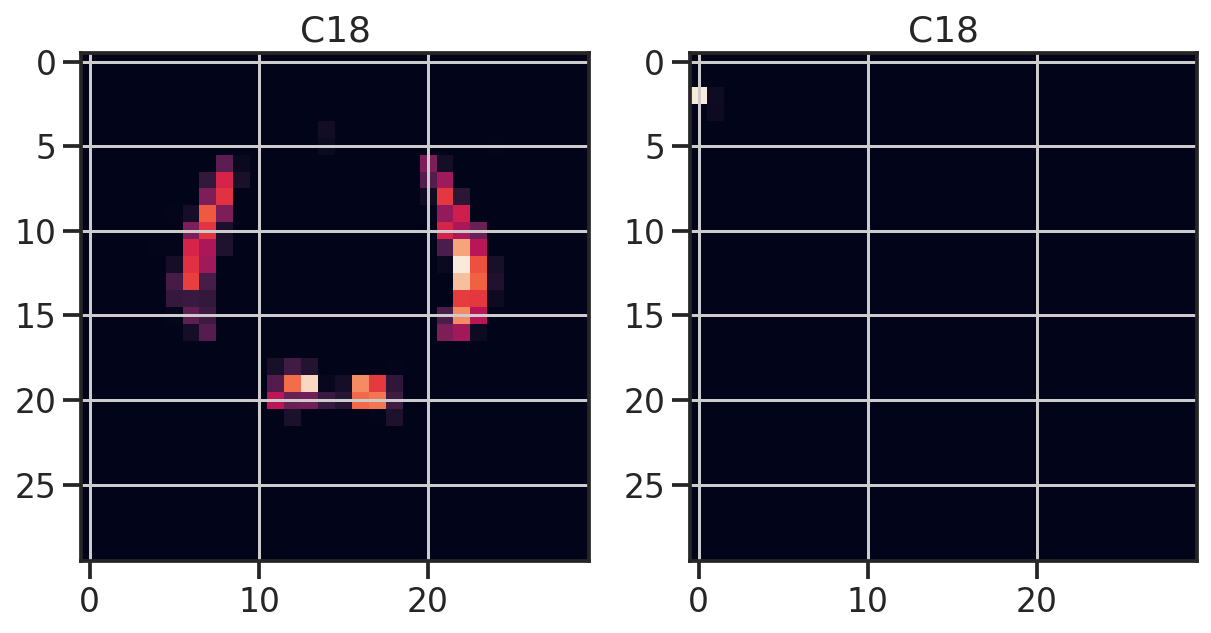

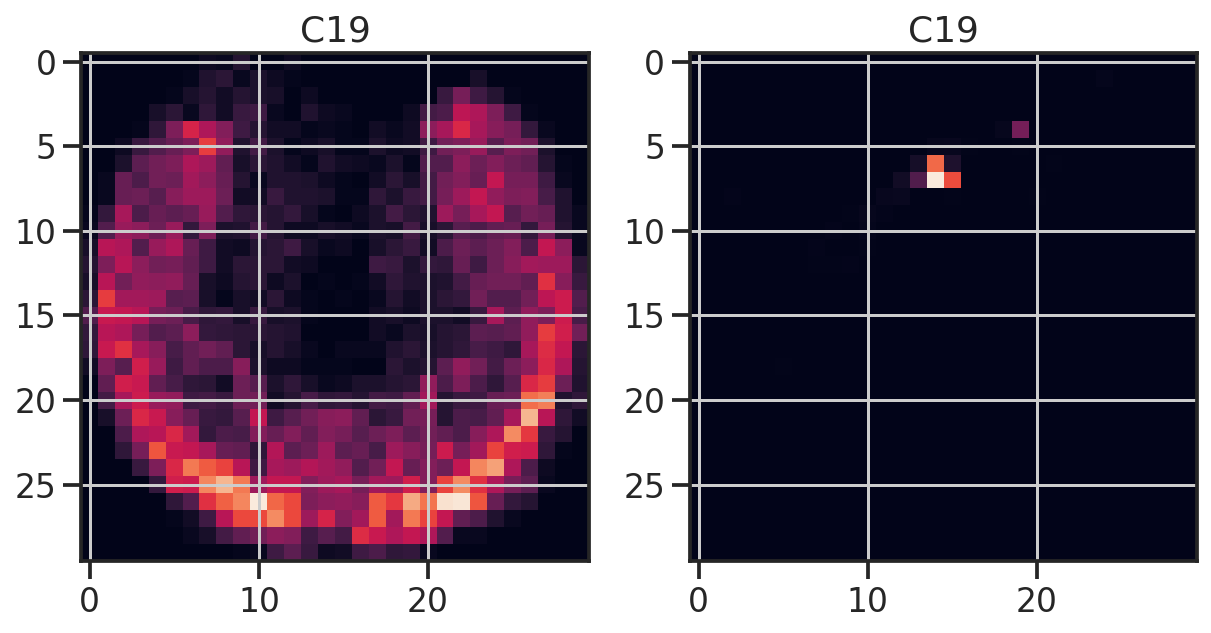

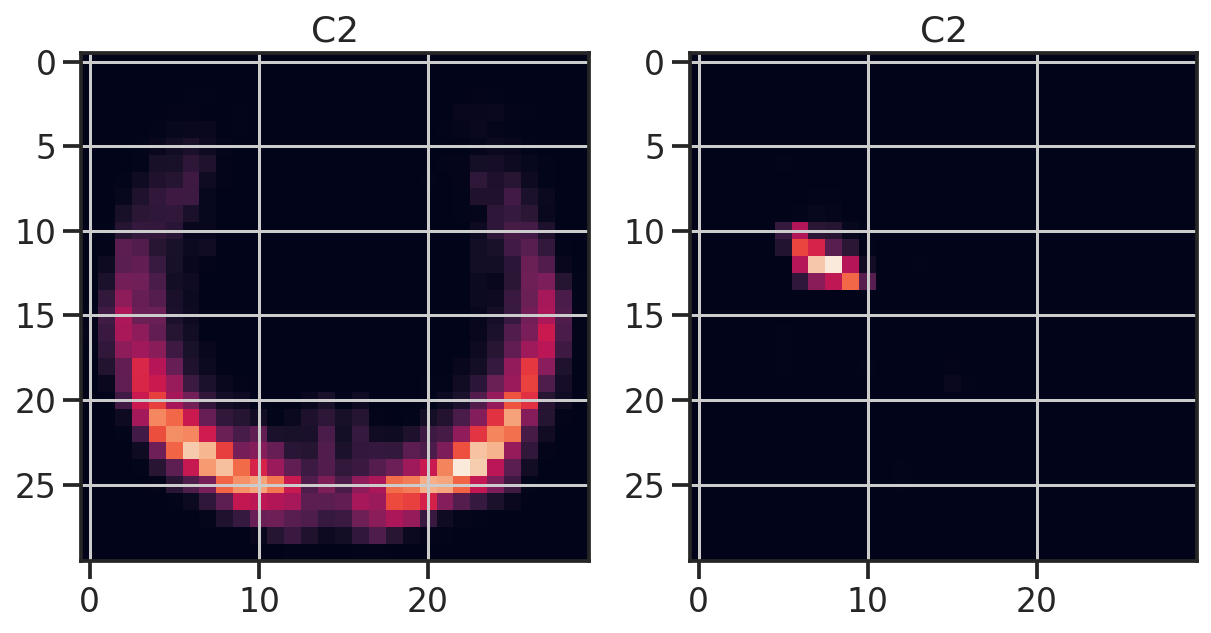

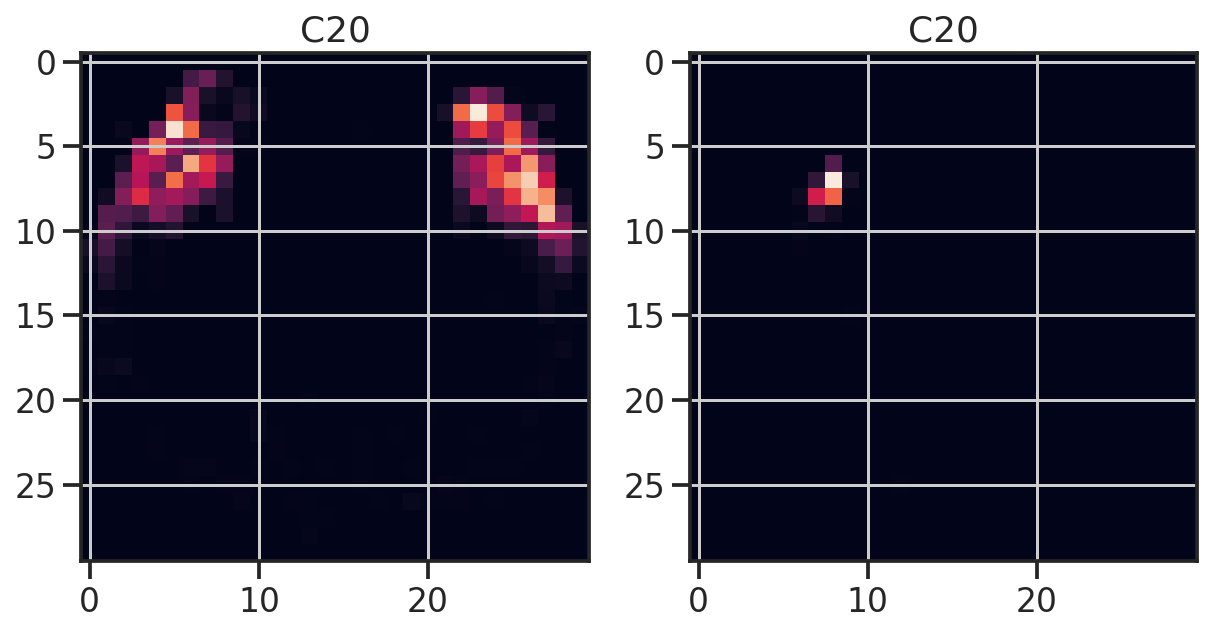

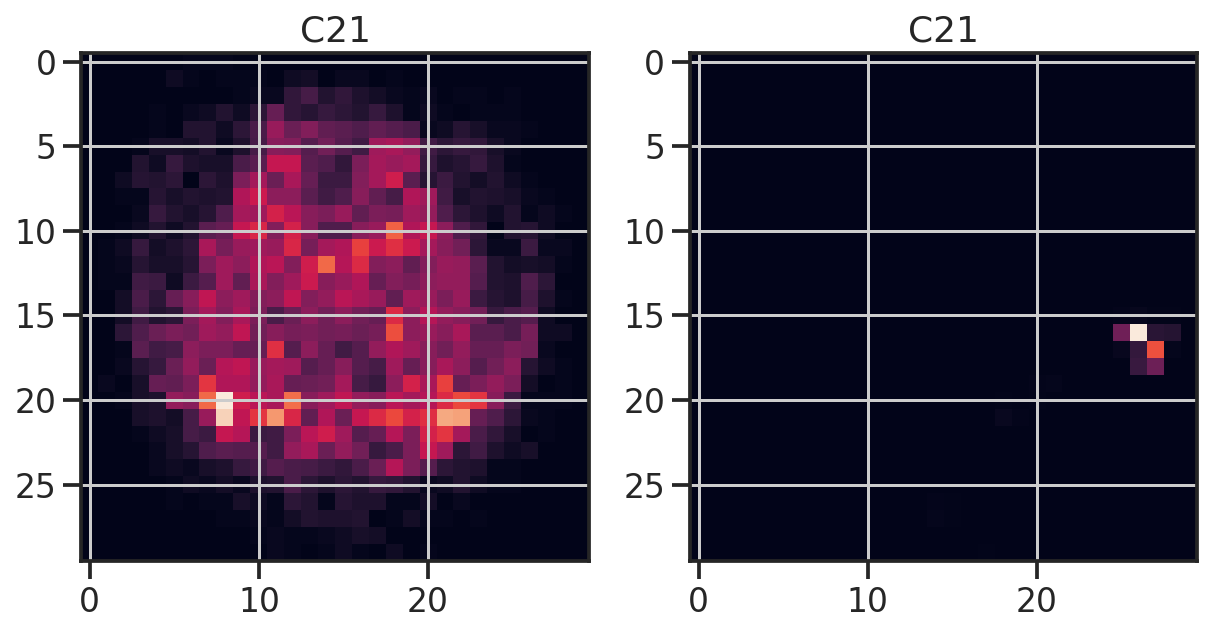

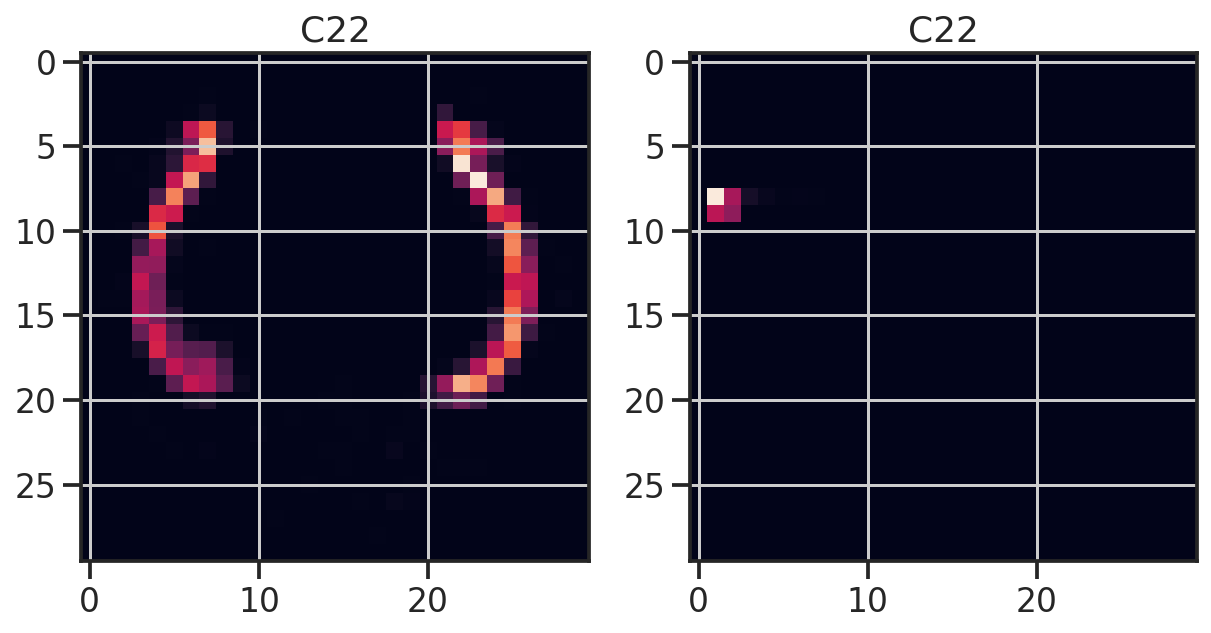

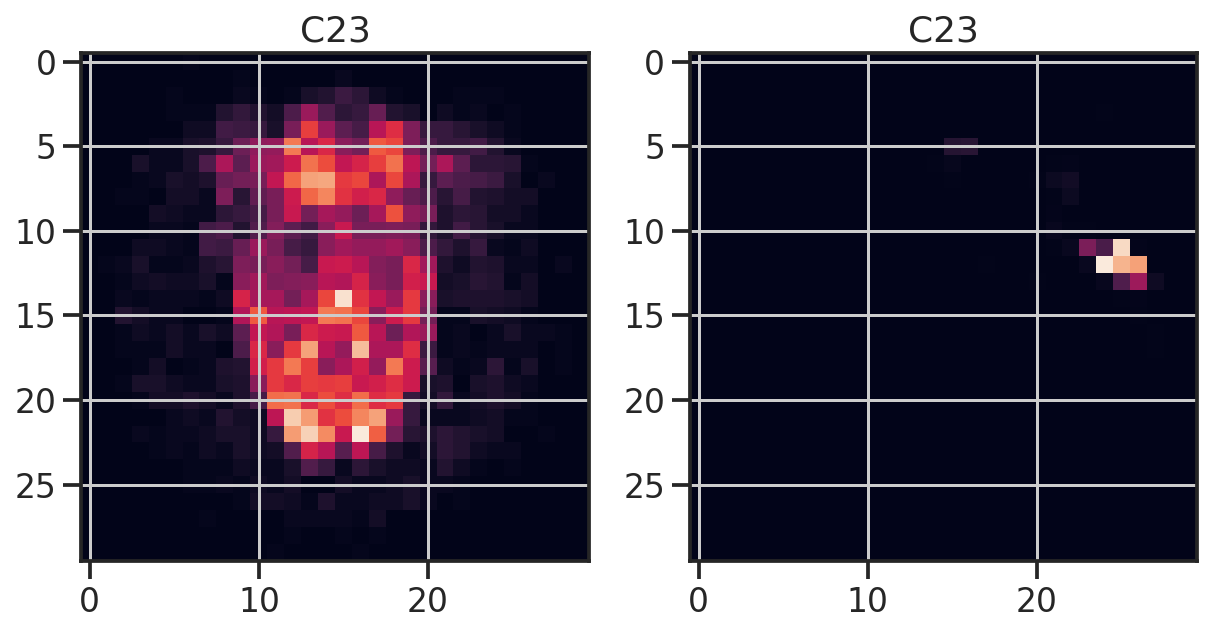

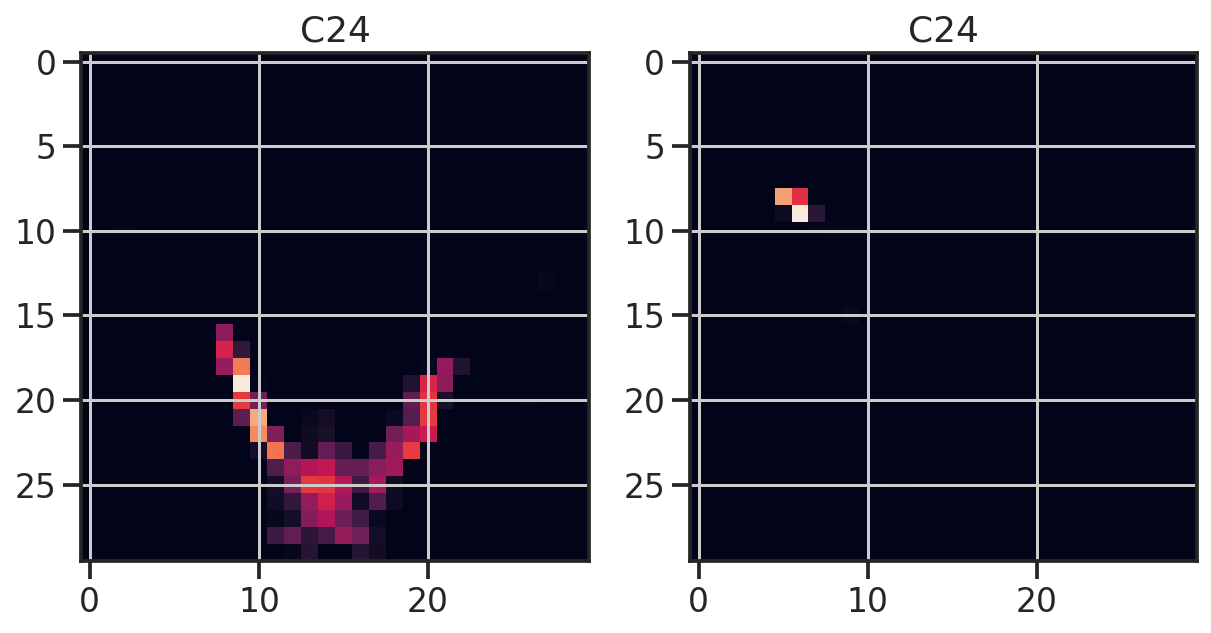

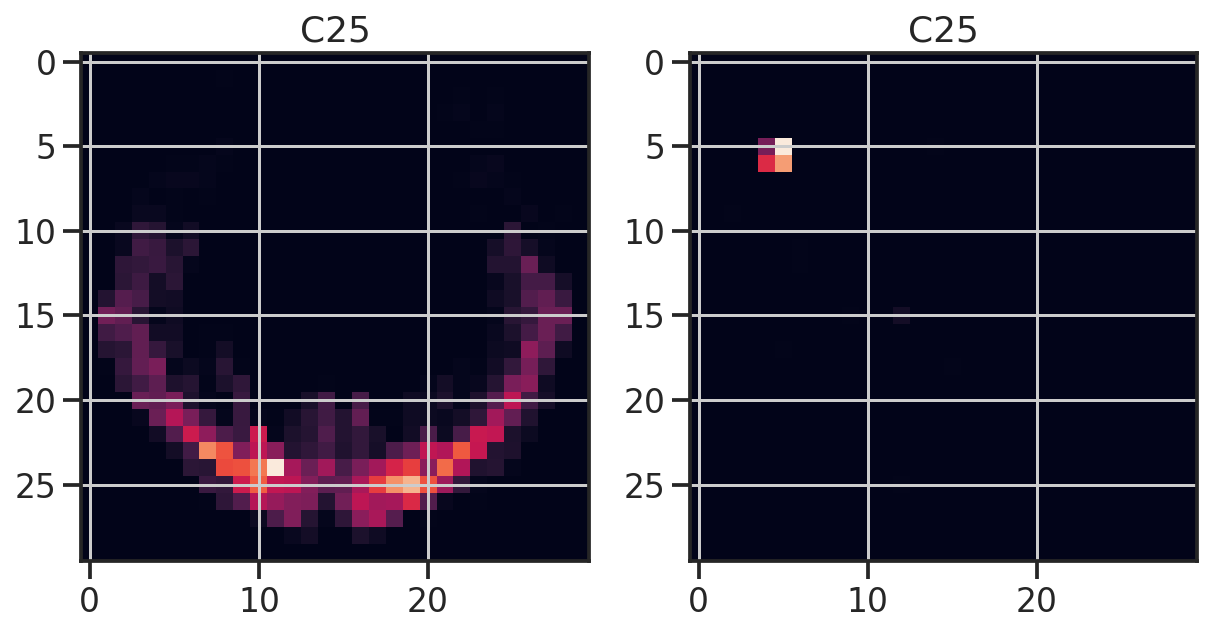

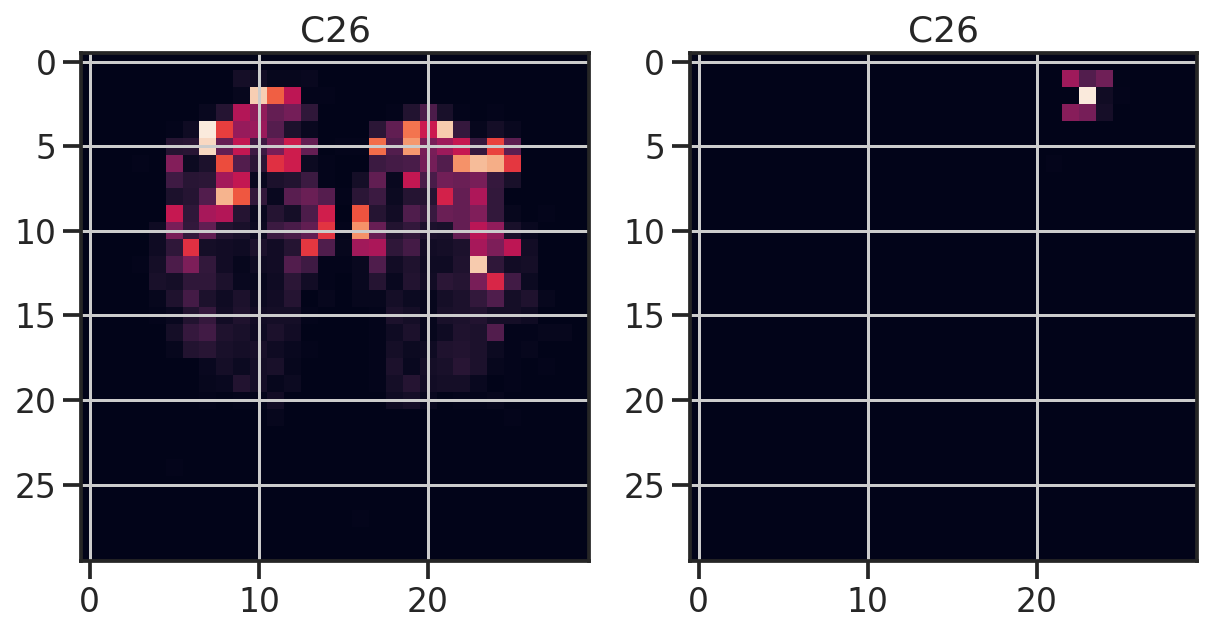

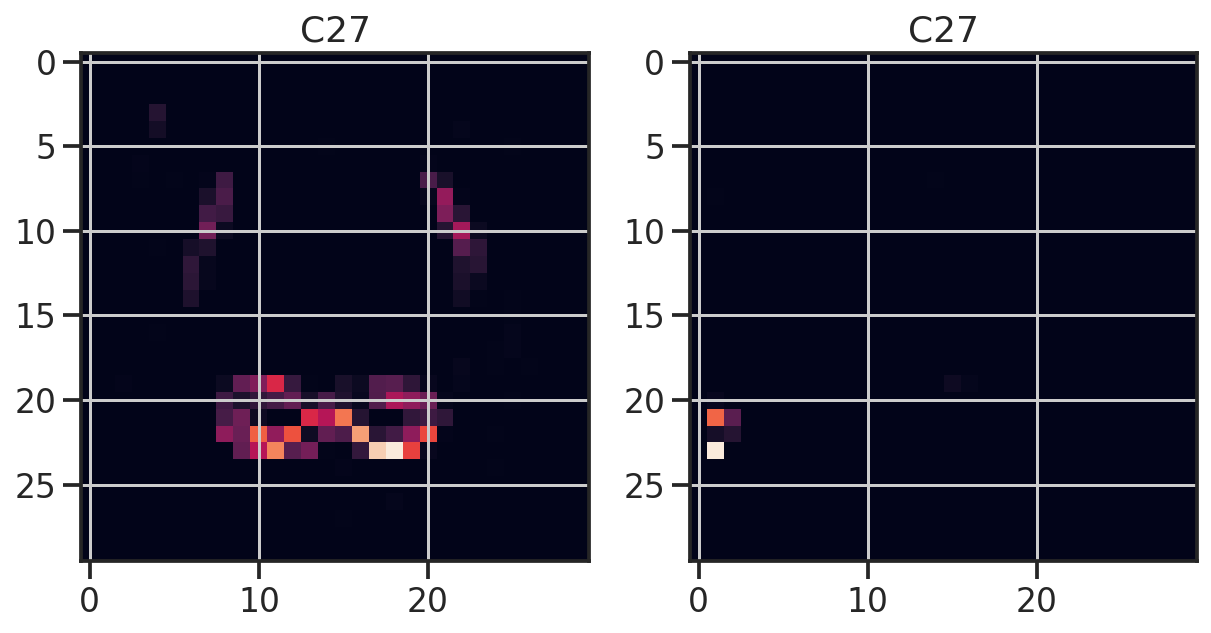

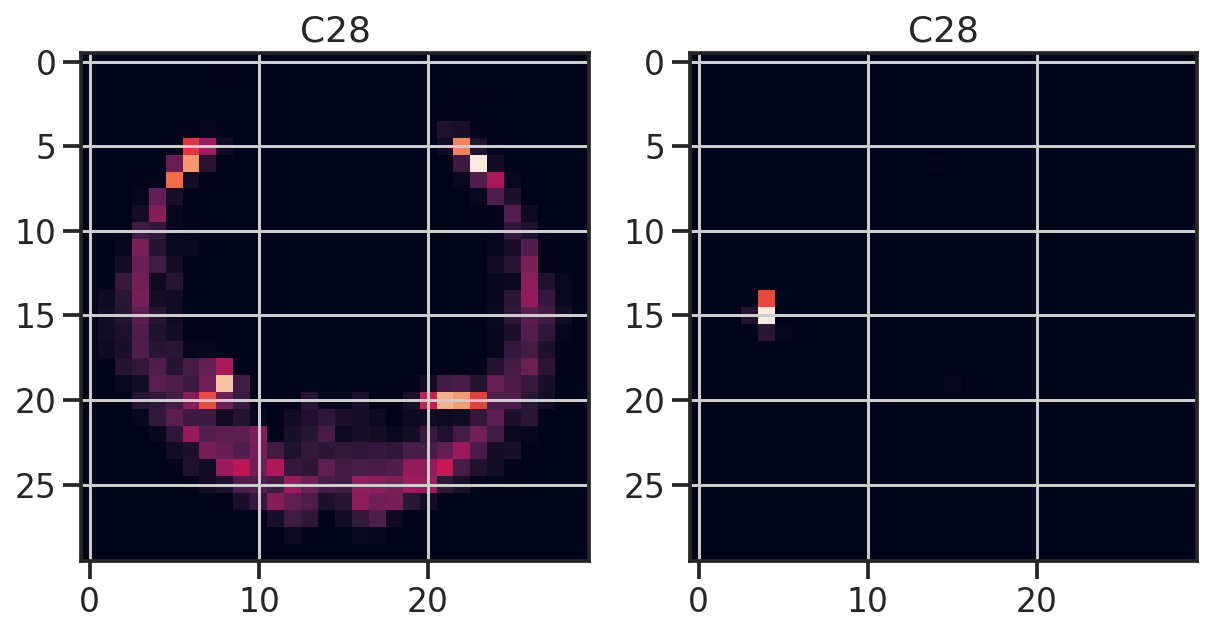

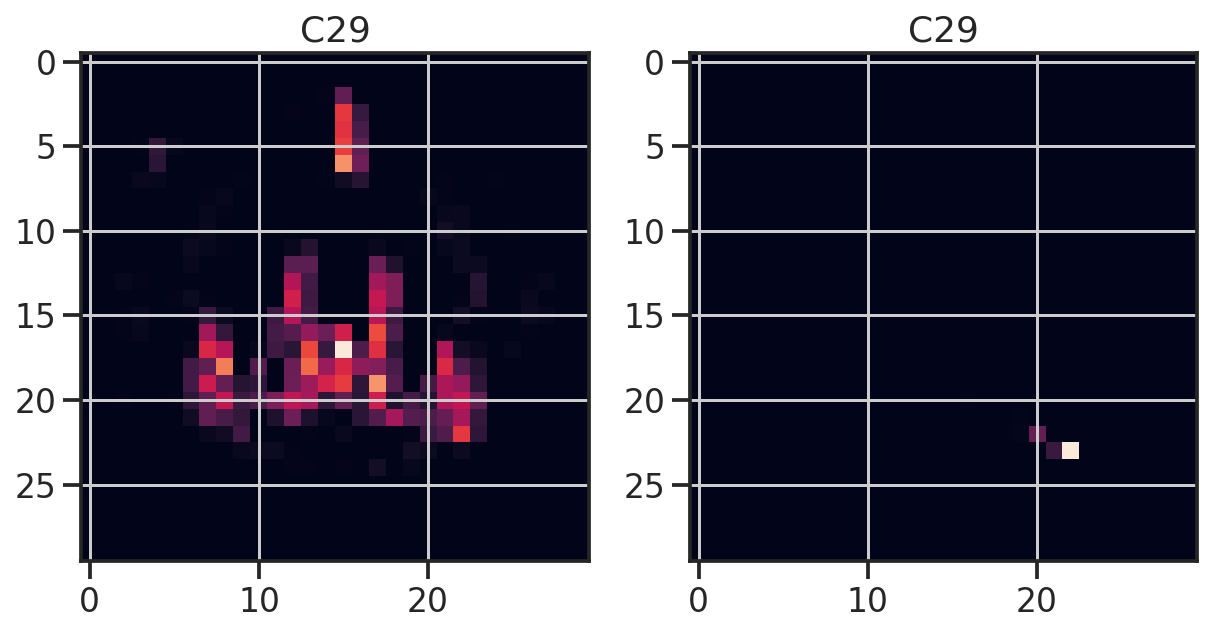

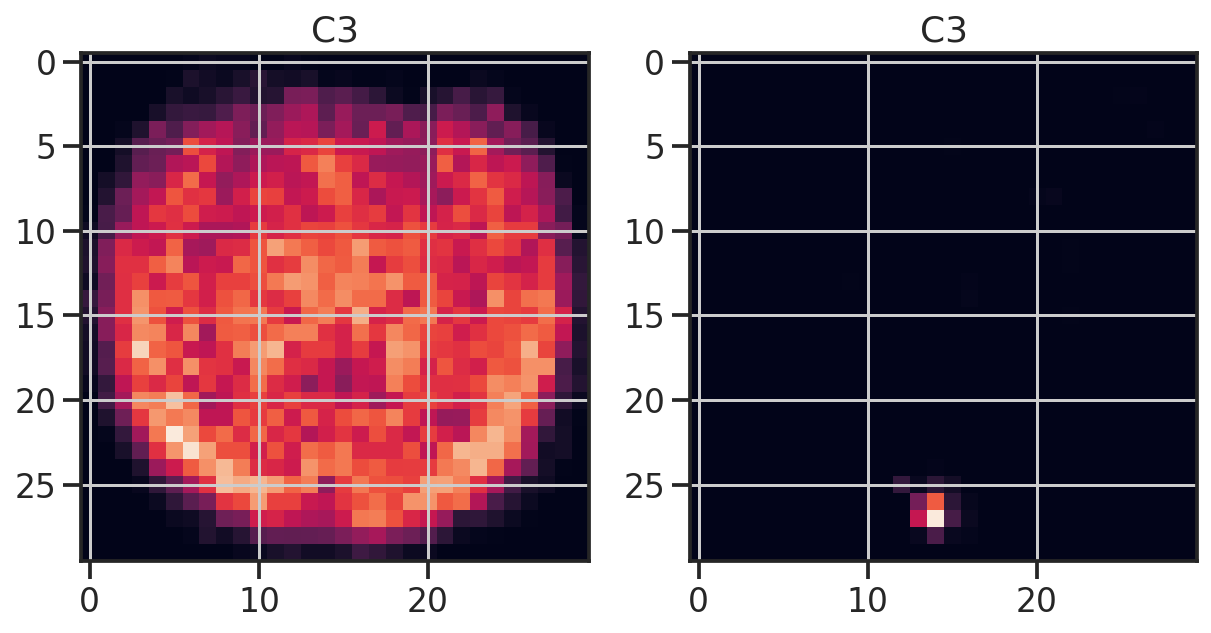

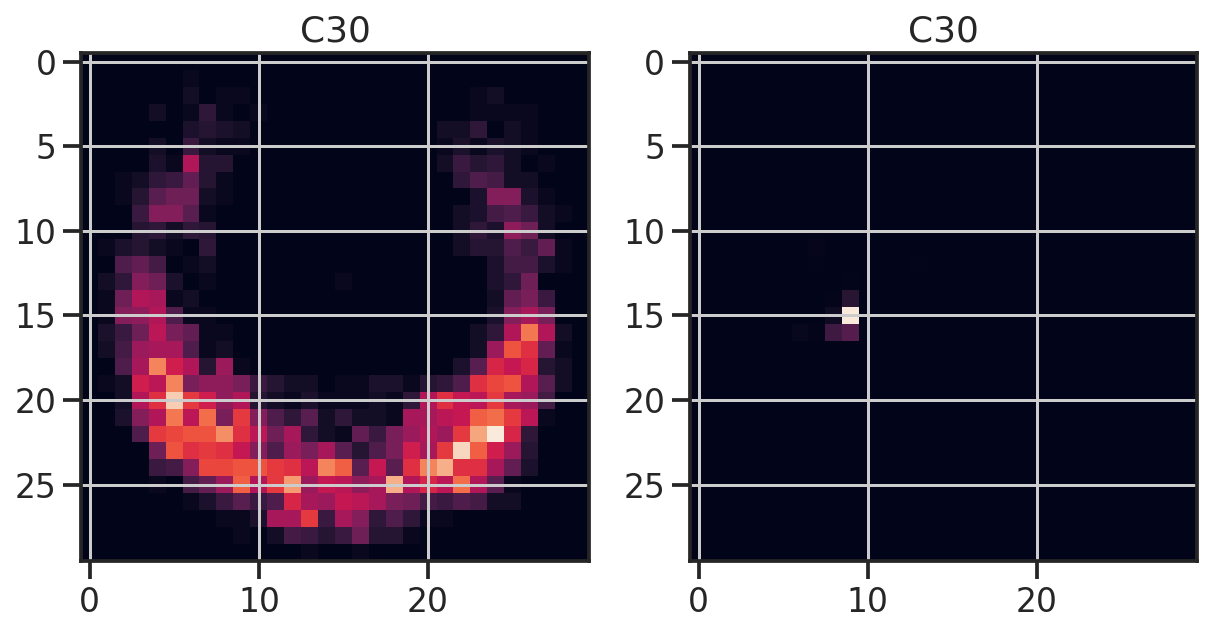

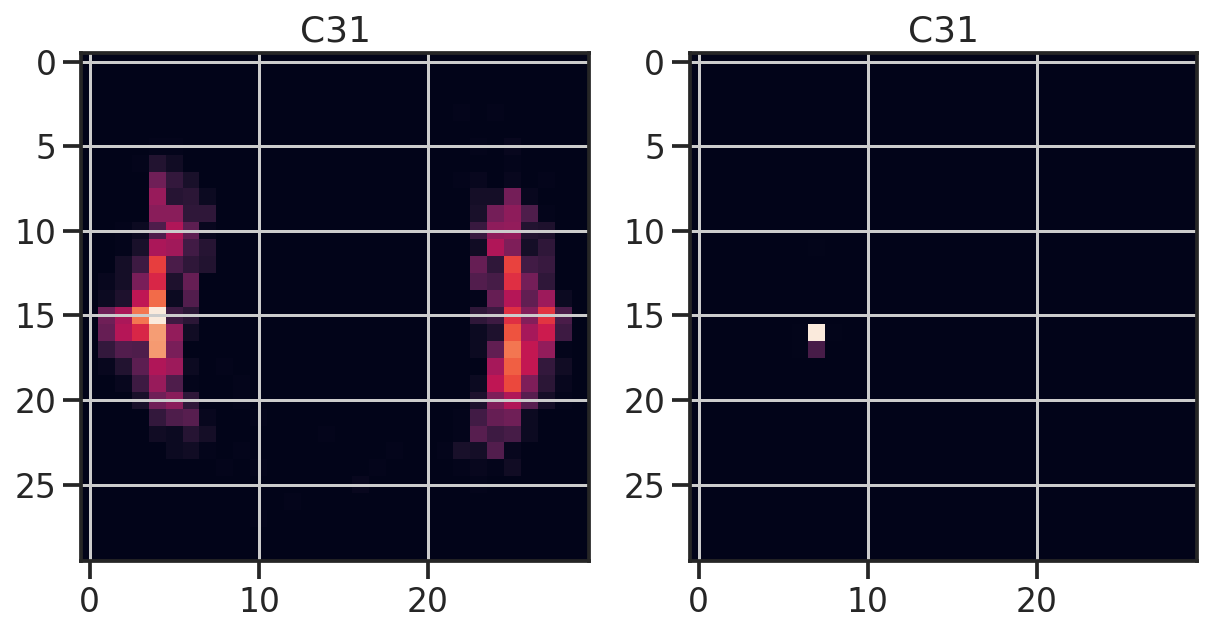

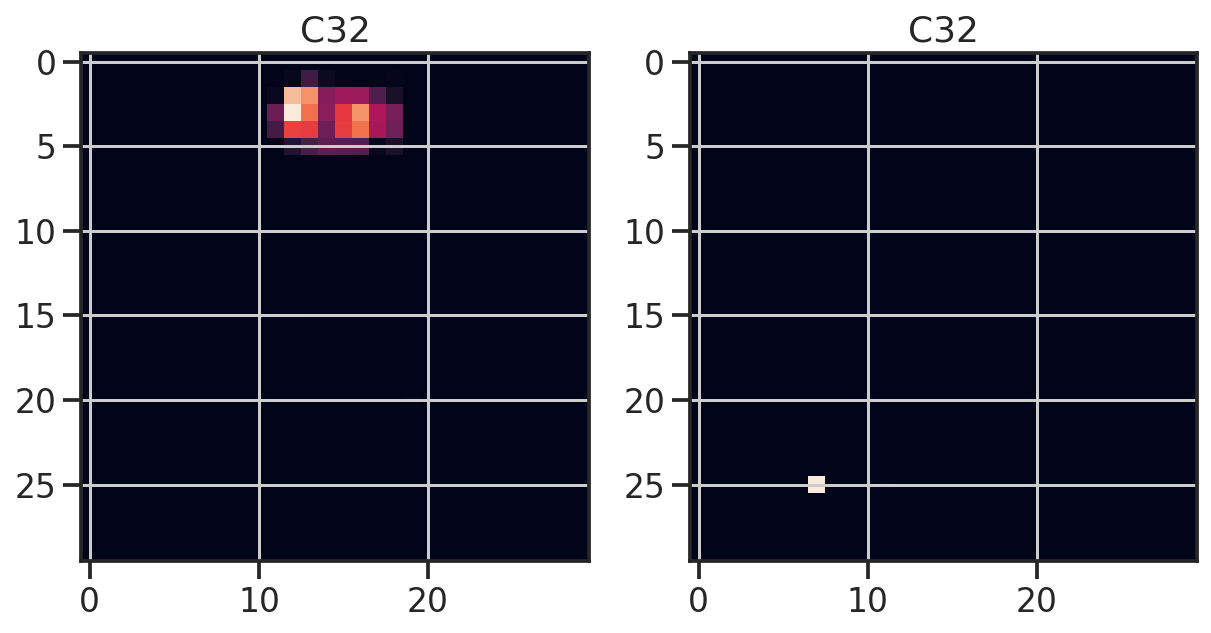

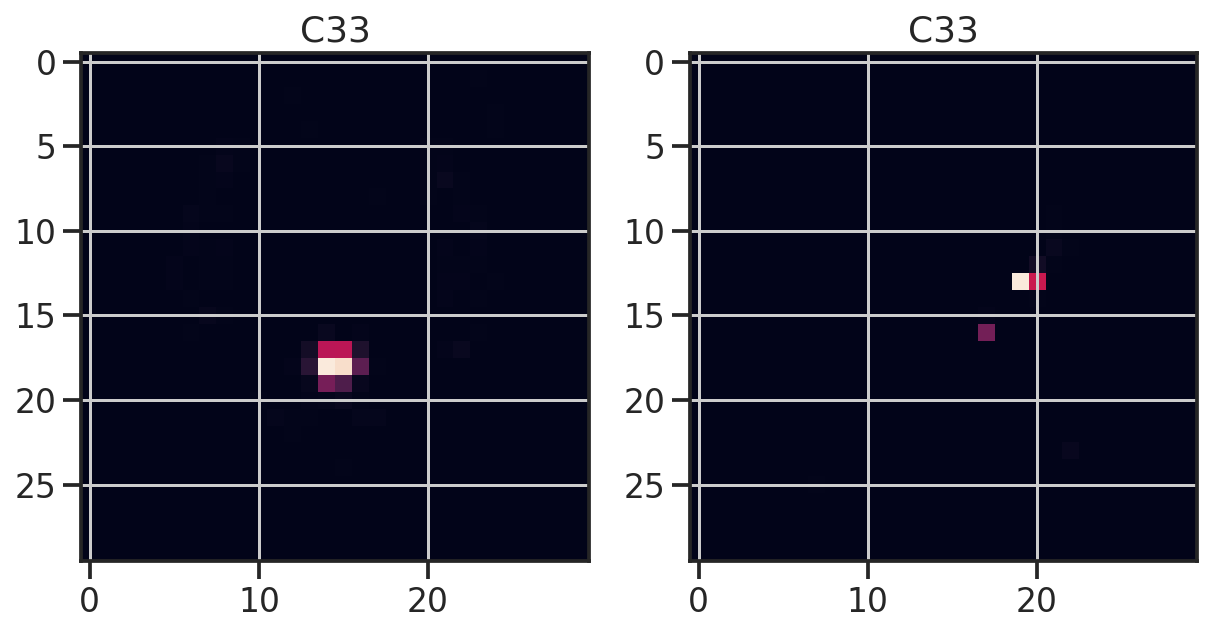

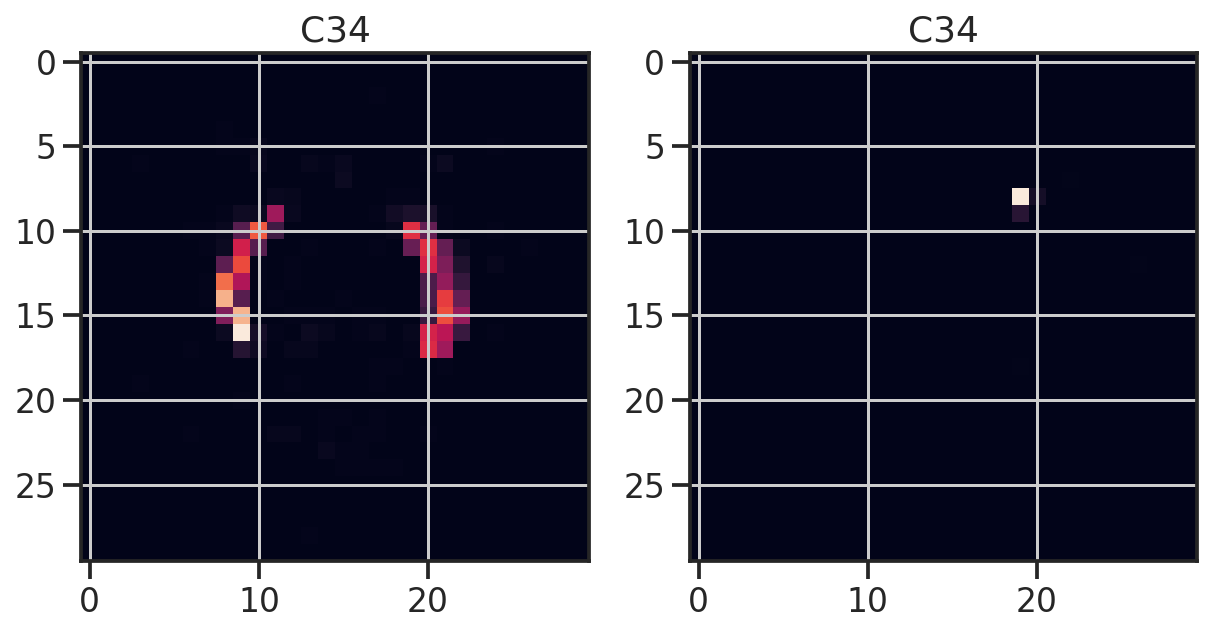

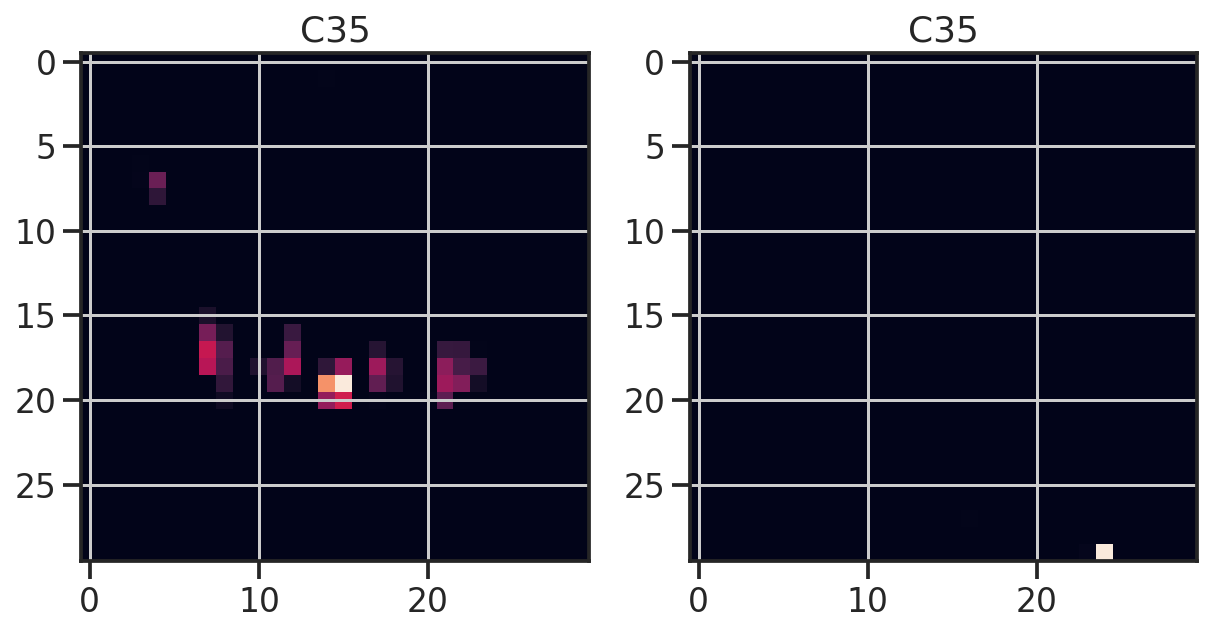

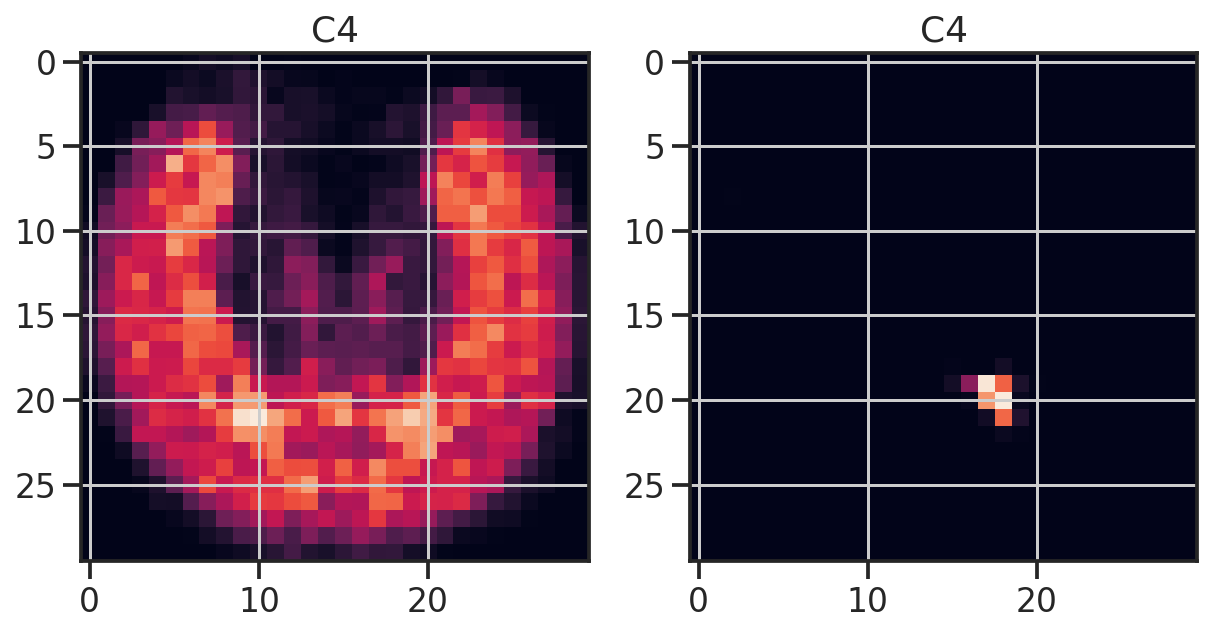

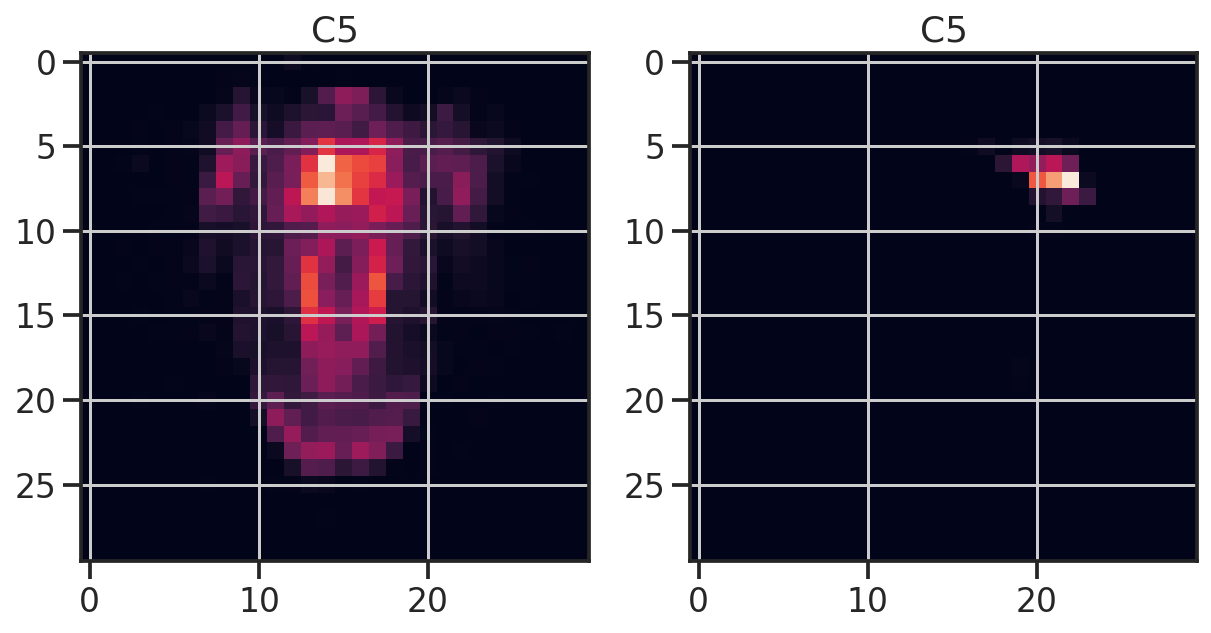

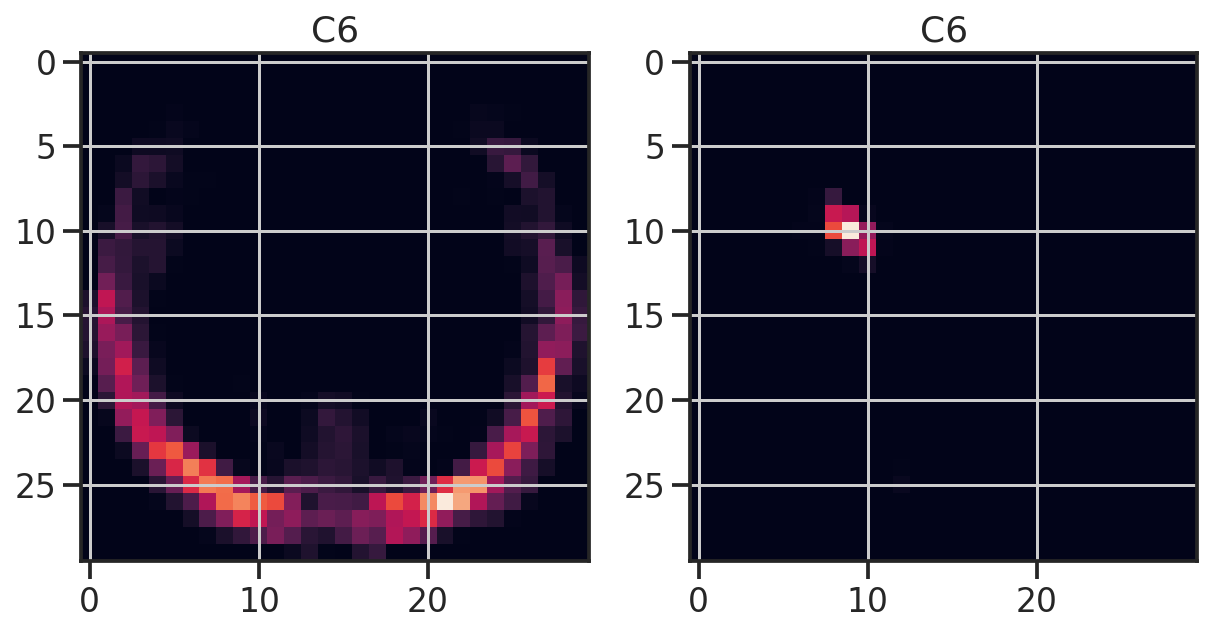

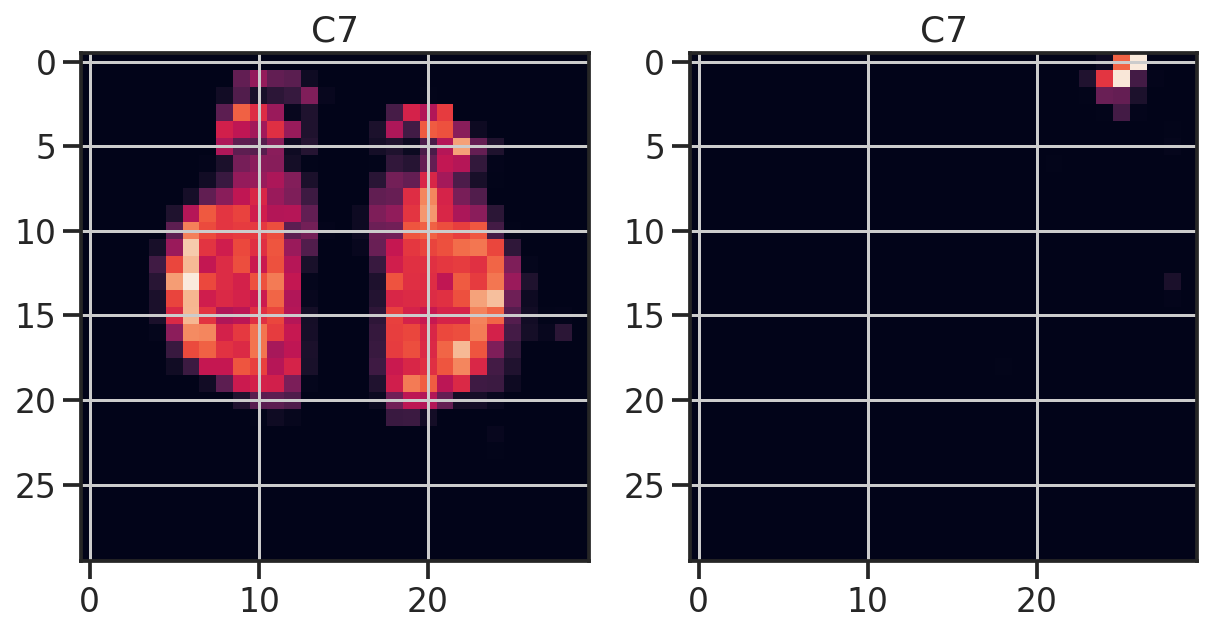

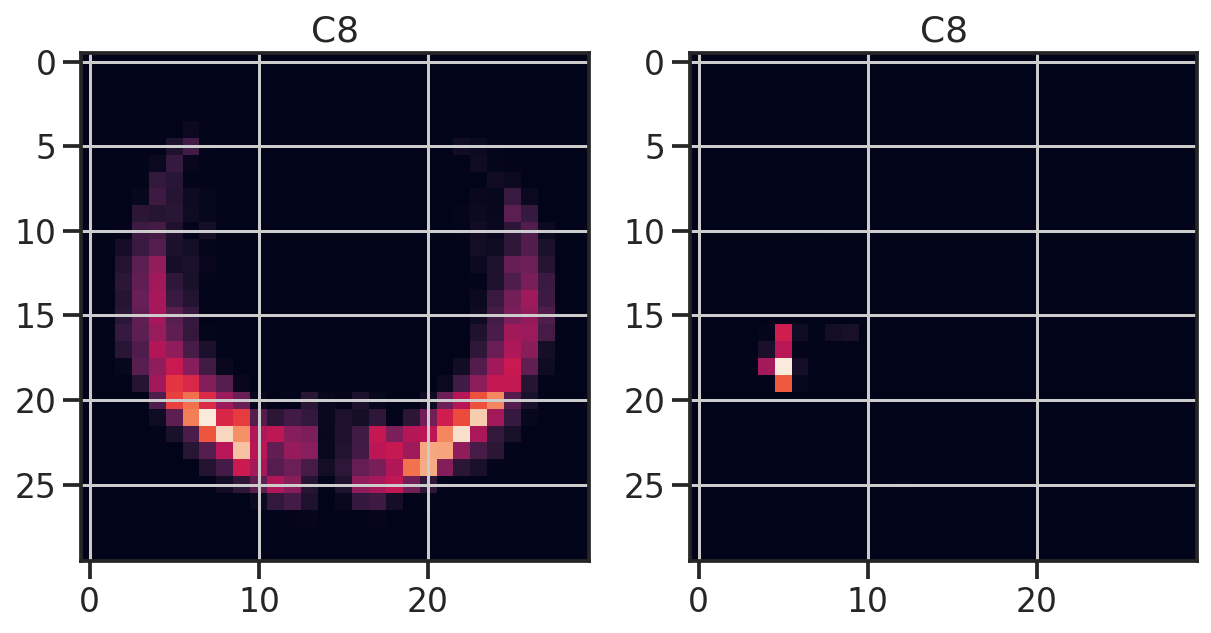

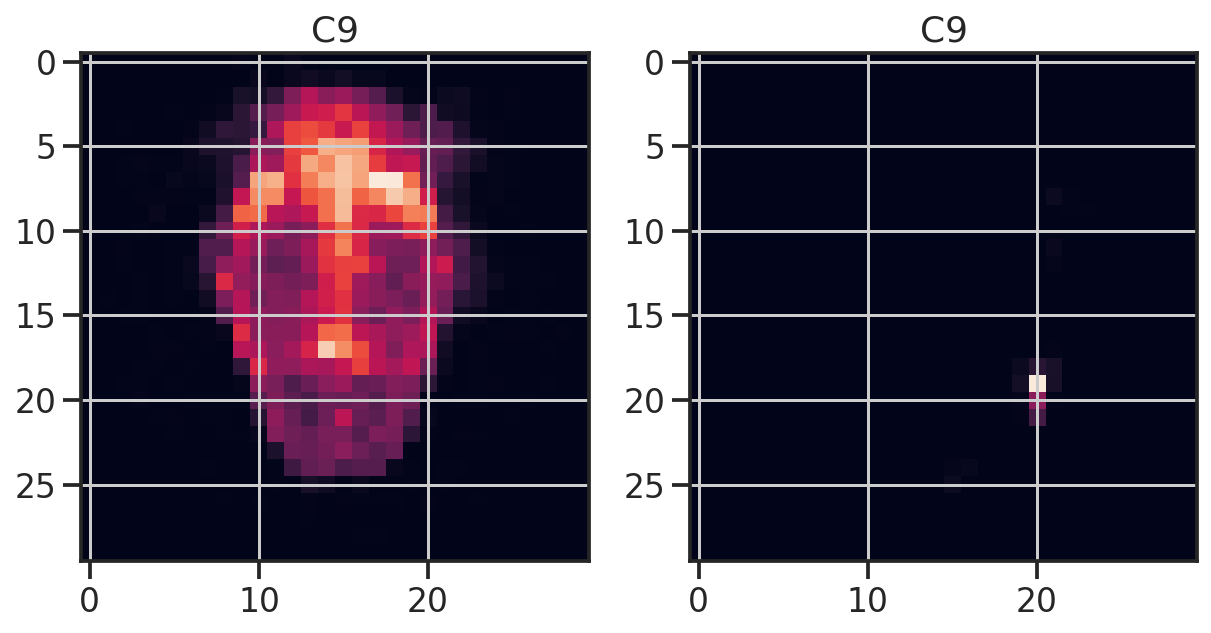

In [59]:

data = thedata
hue = 'cluster_cat'
agg = ds.count_cat(hue)


x, y = 'x', 'y'
aggdata = ds.Canvas(plot_width=30, plot_height=30).points(data, x, y, agg=agg)
x2, y2 = 'umap_1', 'umap_2'
aggdata2 = ds.Canvas(plot_width=30, plot_height=30).points(data, x2, y2, agg=agg)


for i, clst in enumerate(aggdata.coords[hue].values):
    title = clst
    fig, axs = plt.subplots(1, 2, figsize=(5*2,5))
    ax = axs[0]
    ax.imshow(aggdata[:,:,i])
    ax.set_title(title)
    
    ax = axs[1]
    ax.imshow(aggdata2[:,:,i])
    ax.set_title(title)
    
    plt.show()


In [ ]:
x, y = 'x', 'y'
hue = 'C1'
agg = ds.count_cat(hue)
scale_paras = dict(
    npxly=350, 
)
cmap = colorcet.cm.gray_r

fig, axs = plt.subplots(3, 3, figsize=(9*3,6*3))
for ax, sample in zip(axs.flat, samples):
    data = thedatagmat[thedatagmat['sample']==sample]
    title = sample
    plot_insitu_routine(ax, data, x, y, agg, scale_paras, cmap, title)
    
plt.show()

## Todo - visualization solutions

- plot continuous (genes)
- plot categorical (one-by-one)
- plot categorical (deep downsampling)

- other cmap?
- try cellxgene???